<a href="https://colab.research.google.com/github/nkurinsky/THz-FTS/blob/master/python/Notebooks/DataAna/BREADPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In order to run this code, ensure that the data files (from the shared google drive folder "BREAD Experiment" are saved to your personal google drive with the correct folder path:

folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/'

In [292]:
from google.colab import drive
from pylab import figure
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import numpy as np
import scipy as sp
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from pylab import imshow, colorbar

In [293]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [294]:
calculate_chi_sqs = True

In [295]:
#filtertype is a string refering to datafile
#seconds is the number of seconds that the source waited before increasing voltage more
def get_data_auto(filtertype, seconds):
  data_per_second = 5
  indexs = np.arange(0, len(d_0['time_' + filtertype]), data_per_second*seconds)
  averages = []
  std_errors = []
  voltages = []
  
  for x in d_0['time_log_' + filtertype]:
    voltages.append(x[0])

  for i in range(len(indexs)-1):
    list1 = d_0['power_' + filtertype][indexs[i]:indexs[i+1]]
    array1 = np.asarray(list1, dtype=np.float32)
    avg = np.mean(array1)
    
    std_dev = np.sqrt(np.var(array1))
    std_error = std_dev/np.sqrt(len(list1))
    averages.append(avg)
    std_errors.append(std_error)
  return voltages, averages, std_errors


In [296]:
def fill_time_log_array(filtertype, seconds, start_v, increase_v):
  data_per_second = 5
  for i in range(int(len(d_0['power_' + filtertype])/(seconds*data_per_second))):
    v = round(start_v + increase_v*i, 5) #round voltage to only 3 numbers
    t0 = d_0['time_' + filtertype][0] + seconds*i
    t1 = d_0['time_' + filtertype][0] + seconds * (i + 1)
    d_0['time_log_' + filtertype].append([v, t0, t1])
  return

In [297]:
# from the IR-Si253 voltage temperature plot (https://www.boselec.com/wp-content/uploads/Linear/IRSources/IRSourcesLiterature/IR-Si253-Series-formerly-IR-18-and-IR-19.pdf), were able to extract data points and fit to a polynomial using excel. 
# The equation seen here is the corresponding relationship between voltage (V) and temperature (K)
# Note that these values are no longer valid after the "plateu" that is seen becasue of the max current in the UPS
def Si253_temp(v):
  t = []
  for i in range(len(v)):
    t.append( -3.5727 * v[i]**2 + 136.61*v[i] + 294.53)
  return t

In [298]:
# from the IR-12K voltage temperature plot (https://www.boselec.com/wp-content/uploads/Linear/IRSources/IRSourcesLiterature/IR-12-and-12K-with-engineering-data-and-reflectors.pdf), were able to extract data points and fit to a polynomial using excel. 
# The equation seen here is the corresponding relationship between voltage (V) and temperature (K)
# Note that these values are no longer valid after the "plateu" that is seen becasue of the max current in the UPS
def IR12K_temp(v):
  t = []
  for i in range(len(v)):
    t.append( -4.4418 * v[i]**2 + 195.04*v[i] + 26.056 + 273.15)
  return t

In [299]:
def get_power(filtertype_volt_array, filtertype_power_array, voltage):
  power = 0
  for i in range(len(filtertype_volt_array)):
    if filtertype_volt_array[i] == voltage:
      power = filtertype_power_array[i]
  return power

In [300]:
def get_fit_range(temp_list, power_list):
  chi_sqs = []
  min_chisq = 99
  start_best = 0
  end_best = 0
  
  for start in range(len(temp_list)):
    chi_sq_start = []
    for end in range(len(temp_list)):
      if start >= end:
        chi_sq_start.append(np.nan)
      else:
        chi_sq = 0.0
        for i in range(start, end):
          p = np.polyfit(np.log10(temp_list[start:end]), np.log10(power_list[start:end]), 1)
          fit_func = np.poly1d(p)
          chi_sq += (np.log10(power_list[i]) - fit_func(np.log10(temp_list[i])))**2/ np.sqrt(abs(fit_func(np.log10(temp_list[i]))))
        chi_sq_start.append(chi_sq)
        if (chi_sq < min_chisq) and (start + int(len(temp_list)/2) <= end) and (start > int(len(temp_list)/8)): #want to include at least half of data points 
          min_chisq = chi_sq
          start_best = start
          end_best = end
          print("min chi squared updated to ", chi_sq, " with range: [", start, ",", end , "]")
    chi_sqs.append(chi_sq_start)
  
  print(chi_sqs)
  total_num = len(chi_sqs)**2/2
  fig = figure(figsize=(8, 6), dpi=100)
  current_cmap = cm.get_cmap()
  current_cmap.set_bad(color='white')
  chi_sqs_array = np.array(chi_sqs)
  imshow(chi_sqs_array/total_num, origin = "lower", aspect = 1) #plots density plot
  colorbar()

  circle = plt.Circle((end_best, start_best), 1, color='r', fill=False)
  plt.gca().add_artist(circle)
  
  plt.title("Reduced Chi Squared")
  plt.xlabel("end index for fit")
  plt.ylabel("start index for fit")

  print("the range for fit (including at least 1/2 the data points) is: [", start_best, ',' , end_best, "], with chi squared = ", min_chisq)
  return(start_best, end_best, min_chisq)

Here is where I define all of the file paths, to get the data out of google drive. There are many variations of the same data run taken with slightly different parameters as an investigation. 

In [301]:
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/'

data_SiWfilter_Si207 = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_SiW_filter.csv")
data_PEWfilter_Si207 = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_PEW_filter.csv")
data_nofilter_Si207 = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_no_filter.csv")
data_nofilter_Si207_633nm = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_no_filter_633nm.csv")
data_nofilter_Si207_1e4nm = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_no_filter_1e4nm.csv")
data_nofilter_Si207_5e4nm = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_no_filter_5e4nm.csv")
data_nofilter_Si207_3e5nm = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_no_filter_3e5nm.csv")

data_SiWfilter_Si253 = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_SiW_filter.csv")
data_PEWfilter_Si253 = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_PEW_filter.csv")
data_nofilter_Si253 = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter.csv")
data_nofilter_Si253_1e5nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_1e5nm.csv")
data_nofilter_Si253_1e4nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_1e4nm.csv")
data_nofilter_Si253_5e4nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_5e4nm.csv")
data_nofilter_Si253_633nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_633nm.csv")
data_nofilter_Si253_6e5nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_6e5nm.csv")
data_nofilter_Si253_3e6nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_3e6nm.csv")
data_nofilter_Si253_3e5nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_3e5nm.csv")
data_nofilter_Si253_30sec = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_30sec.csv")

data_nofilter_Si253_block = pd.read_csv(folder_path + "Si253_block/IR-Si253_no_filter_3e5nm_cardboard.csv")

data_nofilter_IR12K = pd.read_csv(folder_path + "IR-12K_keyhole/IR-12K_no_filter.csv")

data_nofilter_EVF_5551 = pd.read_csv(folder_path + "EVF-5551_keyhole/EVF-5551_no_filter.csv")
data_nofilter_EVF_5551_try2 = pd.read_csv(folder_path + "EVF-5551_keyhole/EVF-5551_no_filter_try2.csv")

data_nofilter_EVF_5550 = pd.read_csv(folder_path + "EVF-5550_keyhole/EVF-5550_no_filter.csv")
data_nofilter_EVF_5550_try2 = pd.read_csv(folder_path + "EVF-5550_keyhole/EVF-5550_no_filter_try2.csv")

data_LED_nofilter = pd.read_csv(folder_path + "LED/LED_nofilter.csv")
data_LED_SiWfilter1 = pd.read_csv(folder_path + "LED/LED_SiWfilter_1.csv")
data_LED_SiWfilter2 = pd.read_csv(folder_path + "LED/LED_SiWfilter_2.csv")
data_LED_PEWfilter1 = pd.read_csv(folder_path + "LED/LED_PEWfilter_1.csv")
data_LED_PEWfilter2 = pd.read_csv(folder_path + "LED/LED_PEWfilter_2.csv")

data_nosource = pd.read_csv(folder_path + "nosource.csv")

Si253_temp_manual = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual.csv")
Si207_temp_manual = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si207_temp_manual.csv")
IR12K_temp_manual = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/IR-12K_temp_manual.csv")

## Si253 Source Plots

In [302]:
d_0 = {
'time_log_nofilter_Si253' : [],
'time_log_nofilter_Si253_633nm' : [],
'time_log_nofilter_Si253_1e5nm' : [],
'time_log_nofilter_Si253_1e4nm' : [],
'time_log_nofilter_Si253_5e4nm' : [],
'time_log_nofilter_Si253_6e5nm' : [],
'time_log_nofilter_Si253_3e5nm' : [],
'time_log_nofilter_Si253_3e6nm' : [],
'time_log_nofilter_Si253_30sec' : [],
'time_log_nofilter_Si253_block' : [],
'time_log_PEWfilter_Si253' : [],
'time_log_SiWfilter_Si253' : [],

'power_nofilter_Si253' : data_nofilter_Si253['power'],
'time_nofilter_Si253' : np.arange(0, len(data_nofilter_Si253['power'])/5, 0.2),

'power_nofilter_Si253_633nm' : data_nofilter_Si253_633nm['power'],
'time_nofilter_Si253_633nm' : np.arange(0, len(data_nofilter_Si253_633nm['power'])/5, 0.2),

'power_nofilter_Si253_1e4nm' : data_nofilter_Si253_1e4nm['power'],
'time_nofilter_Si253_1e4nm' : np.arange(0, len(data_nofilter_Si253_1e4nm['power'])/5, 0.2),

'power_nofilter_Si253_1e5nm' : data_nofilter_Si253_1e5nm['power'],
'time_nofilter_Si253_1e5nm' : np.arange(0, len(data_nofilter_Si253_1e5nm['power'])/5, 0.2),

'power_nofilter_Si253_5e4nm' : data_nofilter_Si253_5e4nm['power'],
'time_nofilter_Si253_5e4nm' : np.arange(0, len(data_nofilter_Si253_5e4nm['power'])/5, 0.2),

'power_nofilter_Si253_6e5nm' : data_nofilter_Si253_6e5nm['power'],
'time_nofilter_Si253_6e5nm' : np.arange(0, len(data_nofilter_Si253_6e5nm['power'])/5, 0.2),

'power_nofilter_Si253_3e5nm' : data_nofilter_Si253_3e5nm['power'],
'time_nofilter_Si253_3e5nm' : np.arange(0, len(data_nofilter_Si253_3e5nm['power'])/5, 0.2),

'power_nofilter_Si253_3e6nm' : data_nofilter_Si253_3e6nm['power'],
'time_nofilter_Si253_3e6nm' : np.arange(0, len(data_nofilter_Si253_3e6nm['power'])/5, 0.2),

'power_nofilter_Si253_30sec' : data_nofilter_Si253_30sec['power'],
'time_nofilter_Si253_30sec' : np.arange(0, len(data_nofilter_Si253_30sec['power'])/5, 0.2),

'power_nofilter_Si253_block' : data_nofilter_Si253_block['power'],
'time_nofilter_Si253_block' : np.arange(0, len(data_nofilter_Si253_block['power'])/5, 0.2),

'power_PEWfilter_Si253' : data_PEWfilter_Si253['power'],
'time_PEWfilter_Si253' : np.arange(0, len(data_PEWfilter_Si253['power'])/5, 0.2),

'power_SiWfilter_Si253' : data_SiWfilter_Si253['power'],
'time_SiWfilter_Si253' : np.arange(0, len(data_SiWfilter_Si253['power'])/5, 0.2)
}

seconds = 15
start_v = 1.1 #V
increase_v = 0.1 #V
fill_time_log_array('SiWfilter_Si253', seconds, start_v, increase_v)
fill_time_log_array('PEWfilter_Si253', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_633nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_1e5nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_1e4nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_5e4nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_3e5nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_3e6nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_6e5nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_30sec', 30, start_v, increase_v)
fill_time_log_array('nofilter_Si253_block', seconds, start_v, increase_v)

nofilter_voltages_Si253, nofilter_averages_Si253, nofilter_std_error_Si253 = get_data_auto('nofilter_Si253', seconds)
nofilter_voltages_Si253_633nm, nofilter_averages_Si253_633nm, nofilter_std_error_Si253_633nm = get_data_auto('nofilter_Si253_633nm', seconds)
nofilter_voltages_Si253_1e5nm, nofilter_averages_Si253_1e5nm, nofilter_std_error_Si253_1e5nm = get_data_auto('nofilter_Si253_1e5nm', seconds)
nofilter_voltages_Si253_1e4nm, nofilter_averages_Si253_1e4nm, nofilter_std_error_Si253_1e4nm = get_data_auto('nofilter_Si253_1e4nm', seconds)
nofilter_voltages_Si253_5e4nm, nofilter_averages_Si253_5e4nm, nofilter_std_error_Si253_5e4nm = get_data_auto('nofilter_Si253_5e4nm', seconds)
nofilter_voltages_Si253_3e5nm, nofilter_averages_Si253_3e5nm, nofilter_std_error_Si253_3e5nm = get_data_auto('nofilter_Si253_3e5nm', seconds)
nofilter_voltages_Si253_3e6nm, nofilter_averages_Si253_3e6nm, nofilter_std_error_Si253_3e6nm = get_data_auto('nofilter_Si253_3e6nm', seconds)
nofilter_voltages_Si253_6e5nm, nofilter_averages_Si253_6e5nm, nofilter_std_error_Si253_6e5nm = get_data_auto('nofilter_Si253_6e5nm', seconds)
nofilter_voltages_Si253_30sec, nofilter_averages_Si253_30sec, nofilter_std_error_Si253_30sec = get_data_auto('nofilter_Si253_30sec', 30)
nofilter_voltages_Si253_block, nofilter_averages_Si253_block, nofilter_std_error_Si253_block = get_data_auto('nofilter_Si253_block', seconds)
PEWfilter_voltages_Si253, PEWfilter_averages_Si253, PEWfilter_std_error_Si253 = get_data_auto('PEWfilter_Si253', seconds)
SiWfilter_voltages_Si253, SiWfilter_averages_Si253, SiWfilter_std_error_Si253 = get_data_auto('SiWfilter_Si253', seconds)

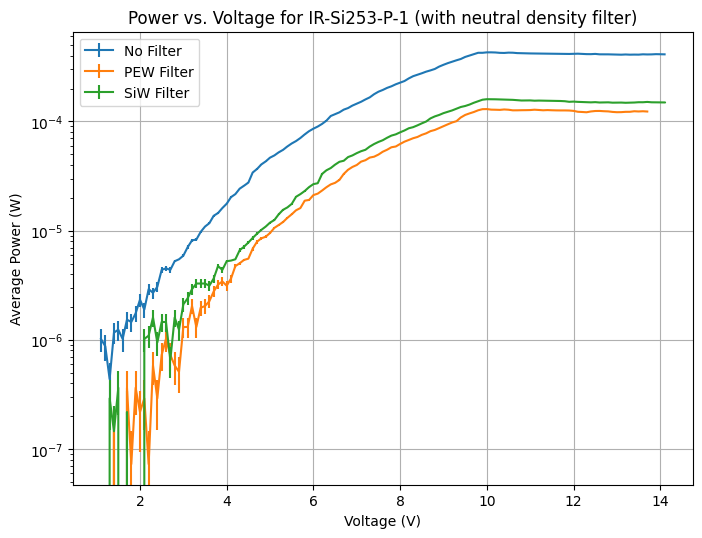

In [303]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si253, nofilter_averages_Si253, yerr = nofilter_std_error_Si253, label = "No Filter")
plt.errorbar(PEWfilter_voltages_Si253, PEWfilter_averages_Si253, yerr = PEWfilter_std_error_Si253, label = "PEW Filter")
plt.errorbar(SiWfilter_voltages_Si253, SiWfilter_averages_Si253, yerr = SiWfilter_std_error_Si253, label = "SiW Filter")
plt.title("Power vs. Voltage for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

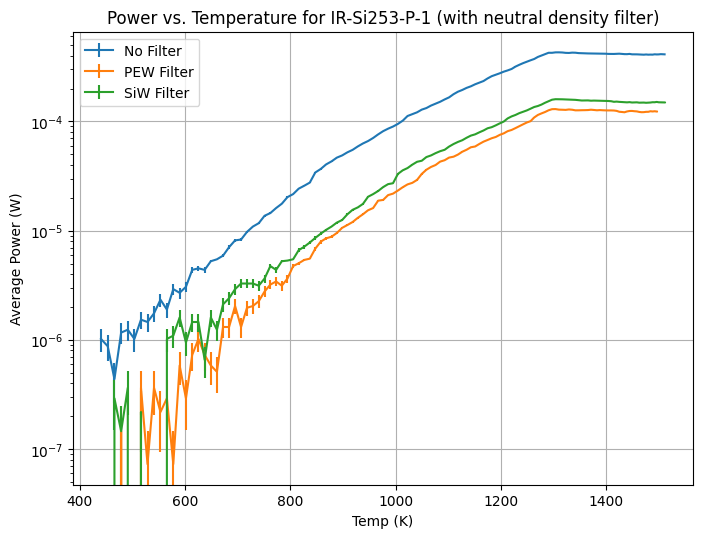

In [304]:
nofilter_temps_Si253 = Si253_temp(nofilter_voltages_Si253)
PEWfilter_temps_Si253 = Si253_temp(PEWfilter_voltages_Si253)
SiWfilter_temps_Si253 = Si253_temp(SiWfilter_voltages_Si253)

fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_temps_Si253, nofilter_averages_Si253, yerr = nofilter_std_error_Si253, label = "No Filter")
plt.errorbar(PEWfilter_temps_Si253, PEWfilter_averages_Si253, yerr = PEWfilter_std_error_Si253, label = "PEW Filter")
plt.errorbar(SiWfilter_temps_Si253, SiWfilter_averages_Si253, yerr = SiWfilter_std_error_Si253, label = "SiW Filter")

plt.title("Power vs. Temperature for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Temp (K)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

This upcoming plot is the most interesting data point for the Si253 source: the Power Law extracted as measured optical power as a function of input power to the source. The first plot is for no filter, the following is for the SiW filter, and the third is for the PEW filter.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

min chi squared updated to  0.021651985392035458  with range: [ 17 , 82 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.020386752710147445  with range: [ 20 , 85 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.019991681455846393  with range: [ 21 , 86 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.01997690381636071  with range: [ 22 , 87 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.017944419390732567  with range: [ 23 , 88 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.017457700868100542  with range: [ 24 , 89 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.017295091695675727  with range: [ 25 , 90 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.01669951860733106  with range: [ 26 , 91 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

[[nan, 1.2891775353317684e-30, 5.156710141327071e-30, 0.0038845312895349616, 0.04322163773107931, 0.051019034495956204, 0.05111115392420191, 0.05575617860660578, 0.055881317876535365, 0.05673759631895275, 0.06099531086388974, 0.061726942727816925, 0.06559259330201521, 0.06560193996996994, 0.06570784596056467, 0.07116909250216599, 0.07292669465366185, 0.07292597102840033, 0.07344905697281918, 0.07347406094843835, 0.0734734392421883, 0.07404388162388931, 0.07525210148689825, 0.07537298739743159, 0.07625363195208071, 0.07735458965343947, 0.07800947125058047, 0.07982490586881598, 0.08077995152226525, 0.08195767512804007, 0.08310510704241274, 0.08534276777674922, 0.0868232955361822, 0.08890305757033097, 0.09029939317414684, 0.09129417759140539, 0.09596786537837328, 0.09991622799010759, 0.10409765554104665, 0.10736600328071433, 0.11041180707306046, 0.11238692230914617, 0.1140047051983307, 0.11508357202279614, 0.11612002542752926, 0.11697029828242793, 0.1175121769766579, 0.11799835334289907, 

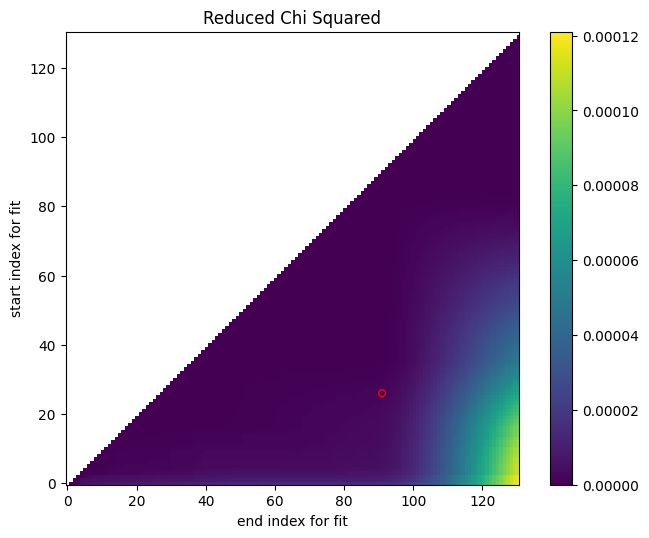

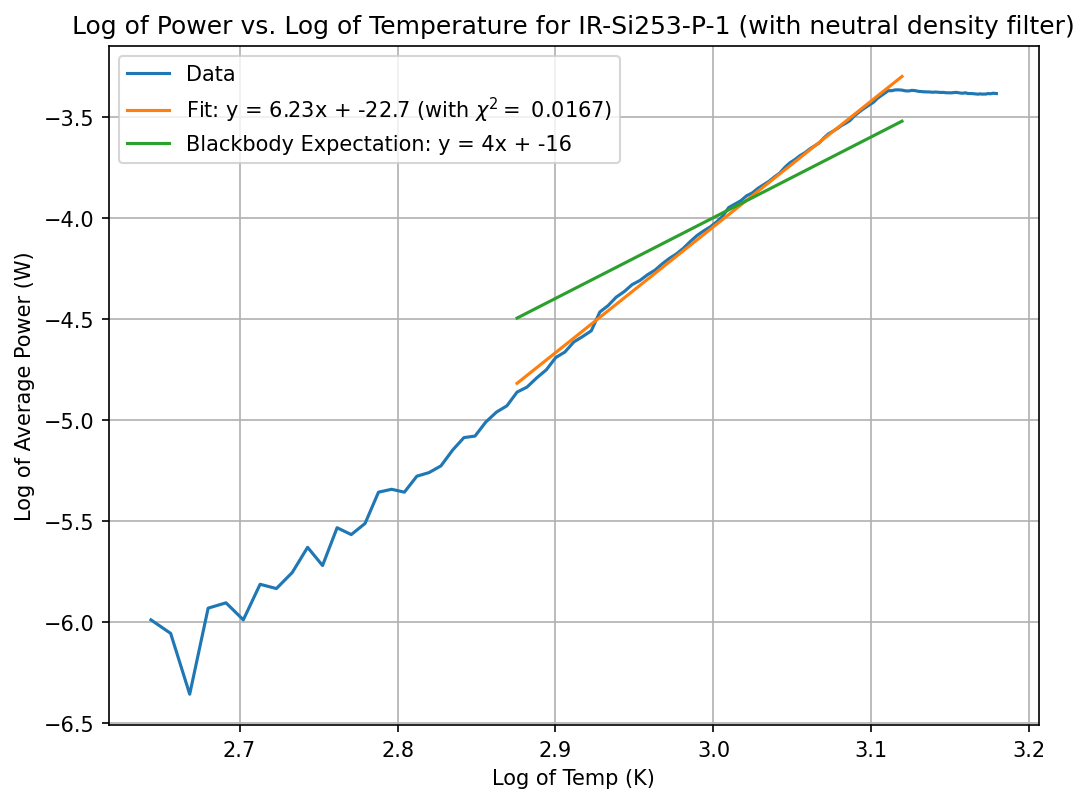

In [305]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)

if calculate_chi_sqs:
  start, end, chi = get_fit_range(nofilter_temps_Si253, nofilter_averages_Si253)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 26
  end = 91
  chi = 0.01669951860733106

fig = figure(figsize=(8, 6), dpi=150)
p, cov = np.polyfit(np.log10(nofilter_temps_Si253[start:end]), np.log10(nofilter_averages_Si253[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit = np.poly1d(p)
fit_string = 'Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit[1], fit[0], chi)
print(fit_string)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 

t = np.linspace(np.log10(nofilter_temps_Si253[start]), np.log10(nofilter_temps_Si253[end]), 100)


plt.plot(np.log10(nofilter_temps_Si253), np.log10(nofilter_averages_Si253), label = "Data")
plt.plot(t, fit(t), label = fit_string)
plt.plot(t, 4*t -16, label = "Blackbody Expectation: y = 4x + -16")
plt.title("Log of Power vs. Log of Temperature for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykern

min chi squared updated to  0.042148854237420555  with range: [ 17 , 82 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


min chi squared updated to  0.041782496594957544  with range: [ 18 , 83 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


min chi squared updated to  0.035528614153747605  with range: [ 19 , 84 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


min chi squared updated to  0.034994934123549815  with range: [ 20 , 85 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


min chi squared updated to  0.03416094946185854  with range: [ 21 , 86 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


min chi squared updated to  0.030748457644981988  with range: [ 22 , 87 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


min chi squared updated to  0.026619754951653314  with range: [ 23 , 88 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


min chi squared updated to  0.025632269123032927  with range: [ 24 , 89 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packa

[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

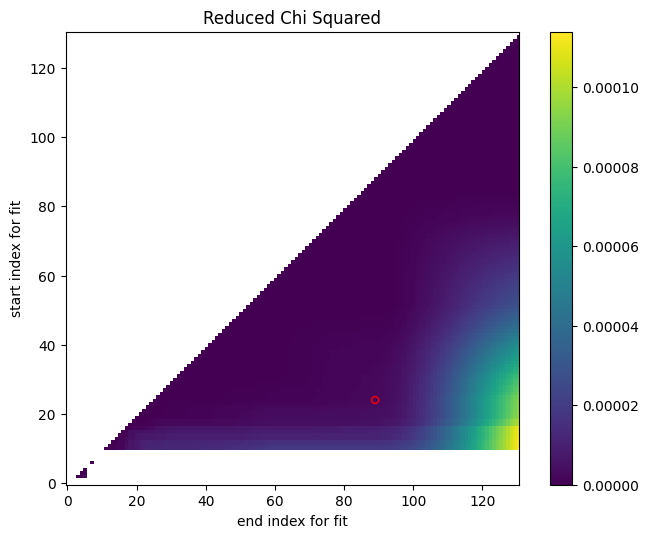

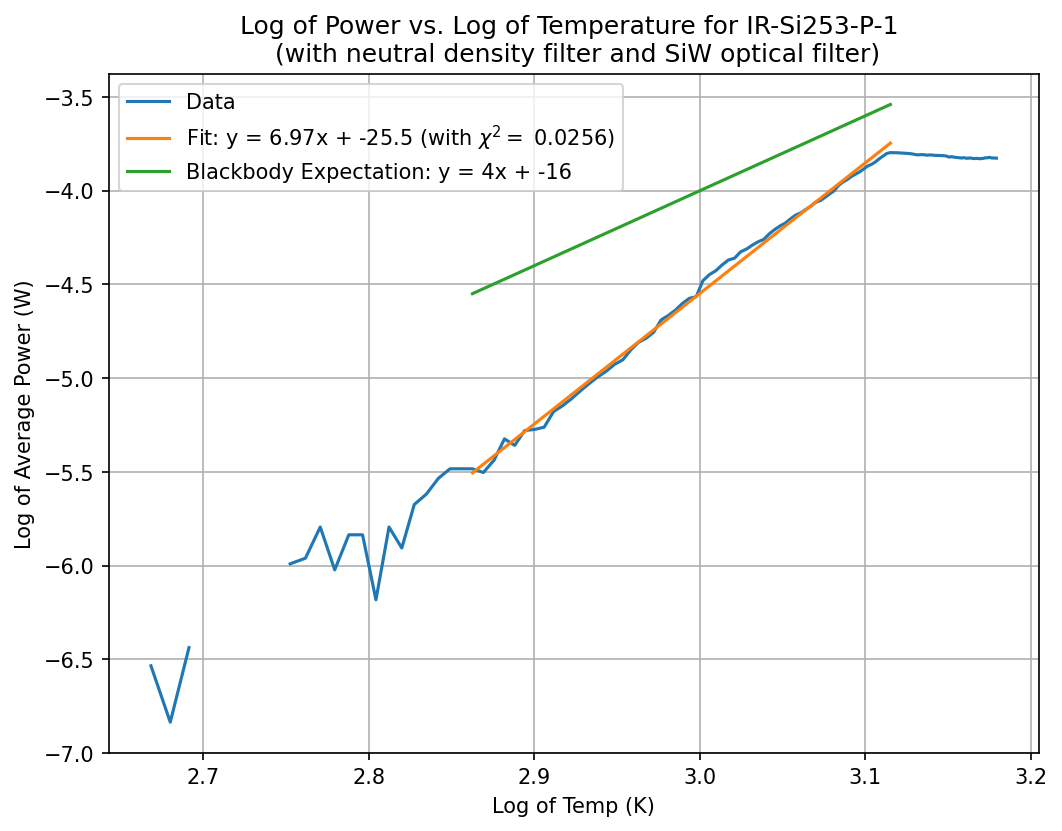

In [306]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)
if calculate_chi_sqs:
  start, end, chi = get_fit_range(SiWfilter_temps_Si253, SiWfilter_averages_Si253)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 24
  end = 89
  chi = 1.6132729404085658e-30

fig = figure(figsize=(8, 6), dpi=150)

p, cov = np.polyfit(np.log10(SiWfilter_temps_Si253[start:end]), np.log10(SiWfilter_averages_Si253[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit_SiW = np.poly1d(p)
fit_string_SiW = 'Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit_SiW[1], fit_SiW[0], chi )
print(fit_string_SiW)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 

t = np.linspace(np.log10(SiWfilter_temps_Si253[start]), np.log10(SiWfilter_temps_Si253[end]), 100)


plt.plot(np.log10(SiWfilter_temps_Si253), np.log10(SiWfilter_averages_Si253), label = "Data")
plt.plot(t, fit_SiW(t), label = fit_string_SiW)
plt.plot(t, 4*t -16, label = "Blackbody Expectation: y = 4x + -16")
plt.title("Log of Power vs. Log of Temperature for IR-Si253-P-1 \n (with neutral density filter and SiW optical filter)")
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after re

min chi squared updated to  0.08611314571449237  with range: [ 16 , 79 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.07544120693213525  with range: [ 18 , 81 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.03406056778989842  with range: [ 19 , 82 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.030394867042234396  with range: [ 22 , 85 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.021985570011630994  with range: [ 25 , 88 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.02072719659076683  with range: [ 26 , 89 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

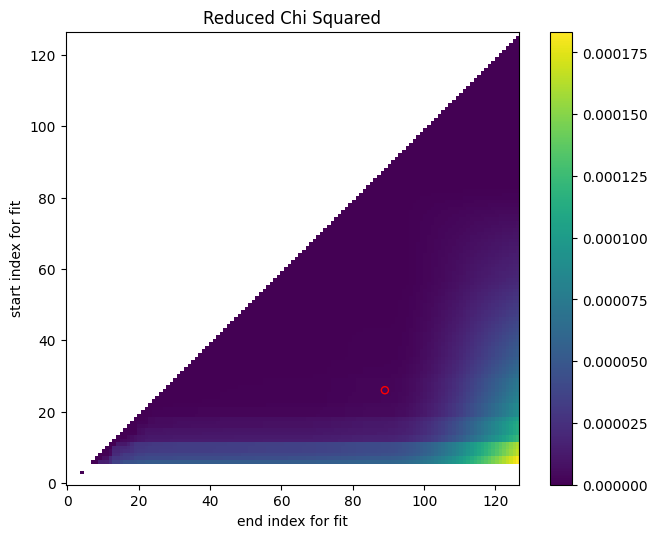

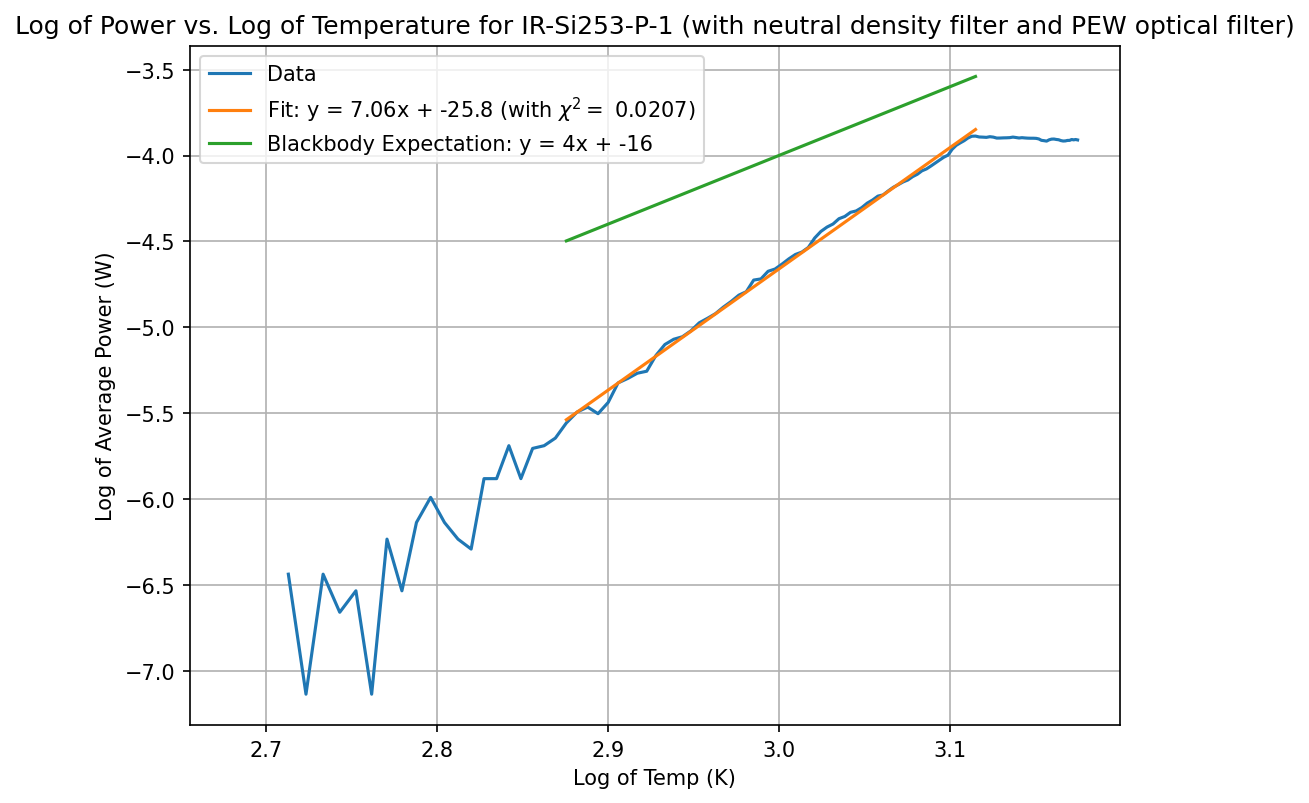

In [307]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)

if calculate_chi_sqs:
  start, end, chi = get_fit_range(PEWfilter_temps_Si253, PEWfilter_averages_Si253)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 26
  end = 89
  chi =  0.02072719659076683

fig = figure(figsize=(8, 6), dpi=150)

p, cov = np.polyfit(np.log10(PEWfilter_temps_Si253[start:end]), np.log10(PEWfilter_averages_Si253[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit_PEW = np.poly1d(p)
fit_string_PEW = 'Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit_PEW[1], fit_PEW[0], chi)
print(fit_string)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 
t = np.linspace(np.log10(PEWfilter_temps_Si253[start]), np.log10(PEWfilter_temps_Si253[end]), 100)


plt.plot(np.log10(PEWfilter_temps_Si253), np.log10(PEWfilter_averages_Si253), label = "Data")
plt.plot(t, fit_PEW(t), label = fit_string_PEW)
plt.plot(t, 4*t -16, label = "Blackbody Expectation: y = 4x + -16")
plt.title("Log of Power vs. Log of Temperature for IR-Si253-P-1 (with neutral density filter and PEW optical filter)")
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

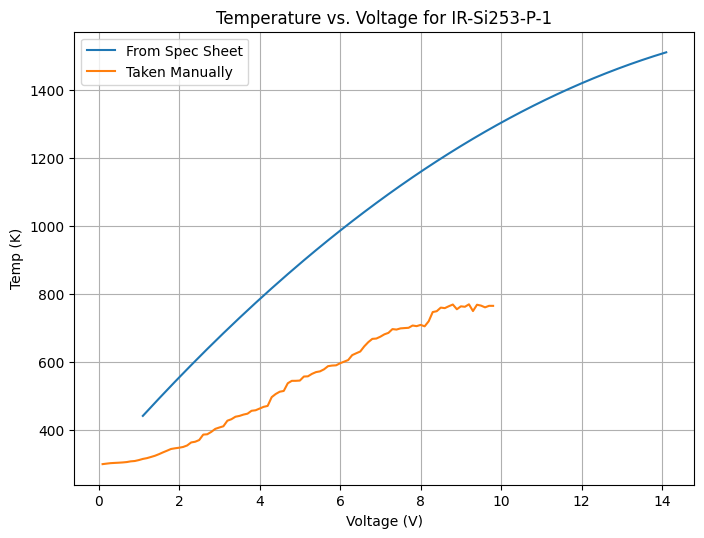

In [308]:
cleanedTempList = [x for x in Si253_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in Si253_temp_manual['Voltage'] if str(x) != 'nan']

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(nofilter_voltages_Si253, nofilter_temps_Si253, label = "From Spec Sheet")
plt.plot(cleanedVoltList, cleanedTempList, label = "Taken Manually")
plt.title("Temperature vs. Voltage for IR-Si253-P-1")
plt.xlabel("Voltage (V)")
plt.ylabel("Temp (K)")

plt.legend()
plt.grid(True)
plt.show()

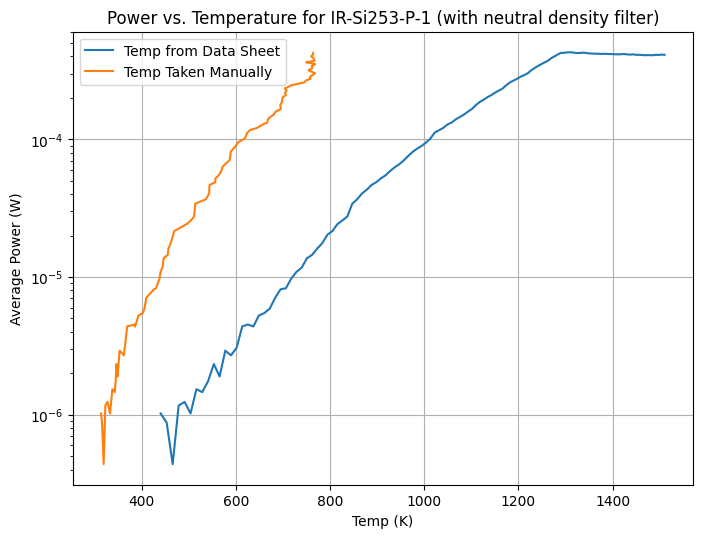

In [309]:
#eliminating any nan elements in the list
cleanedTempList = [x for x in Si253_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in Si253_temp_manual['Voltage'] if str(x) != 'nan']

#constructing a lookup table from voltages to temperatures 
temp_ranges = [cleanedTempList[v] for v in range(len(cleanedVoltList))] 
Si253_volt_to_temp_manual = dict(zip(cleanedVoltList, temp_ranges))

temp = []
power = []
for i in range(len(nofilter_voltages_Si253)):
  if i < len(cleanedTempList)-10:
    temp.append(Si253_volt_to_temp_manual[nofilter_voltages_Si253[i]])
    power.append(nofilter_averages_Si253[i])

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(nofilter_temps_Si253, nofilter_averages_Si253, label = "Temp from Data Sheet")
plt.plot(temp, power, label = "Temp Taken Manually")
plt.title("Power vs. Temperature for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Temp (K)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

min chi squared updated to  0.03220834923595995  with range: [ 12 , 56 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

min chi squared updated to  0.028434636856003444  with range: [ 24 , 68 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.0267146911456968  with range: [ 25 , 69 ]
min chi squared updated to  0.025243919370684393  with range: [ 26 , 70 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

min chi squared updated to  0.024553183367314227  with range: [ 37 , 81 ]
min chi squared updated to  0.023145015969816808  with range: [ 38 , 82 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

[[nan, 1.2891775353317684e-30, 1.0267703358011986e-28, 0.001808371993691639, 0.043594259270925126, 0.048740515486143984, 0.04963151807650259, 0.052138681737018445, 0.05220987597423423, 0.052897461178704815, 0.05875868019554106, 0.05883597043940068, 0.06372467422556642, 0.06446577139096804, 0.06447095905837359, 0.0673287730670081, 0.07042427971331654, 0.07329082136407795, 0.07461588056191865, 0.07927279257463131, 0.08231084145189194, 0.08259402035825497, 0.08632856846073661, 0.09063301914862967, 0.09274346812203145, 0.09311750922777211, 0.09335785665896335, 0.09362598263374557, 0.09372272662472012, 0.09390175293196755, 0.09409082681141427, 0.09483198764081667, 0.09569137693645058, 0.09907702702691179, 0.10449047205677722, 0.10996767864164103, 0.11018290127438063, 0.11715610196830689, 0.12255697078206577, 0.12479955575694422, 0.12530412712577169, 0.12802829189138645, 0.1289642788006304, 0.1305388510613352, 0.1317273255346545, 0.13218528724929493, 0.13289640113697593, 0.13443355477903007,

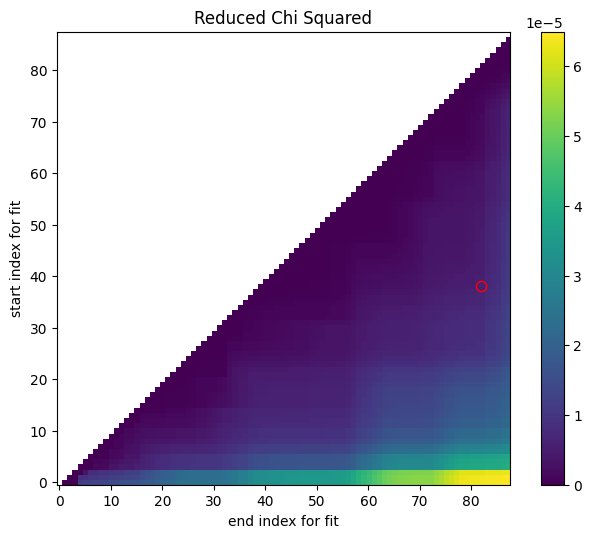

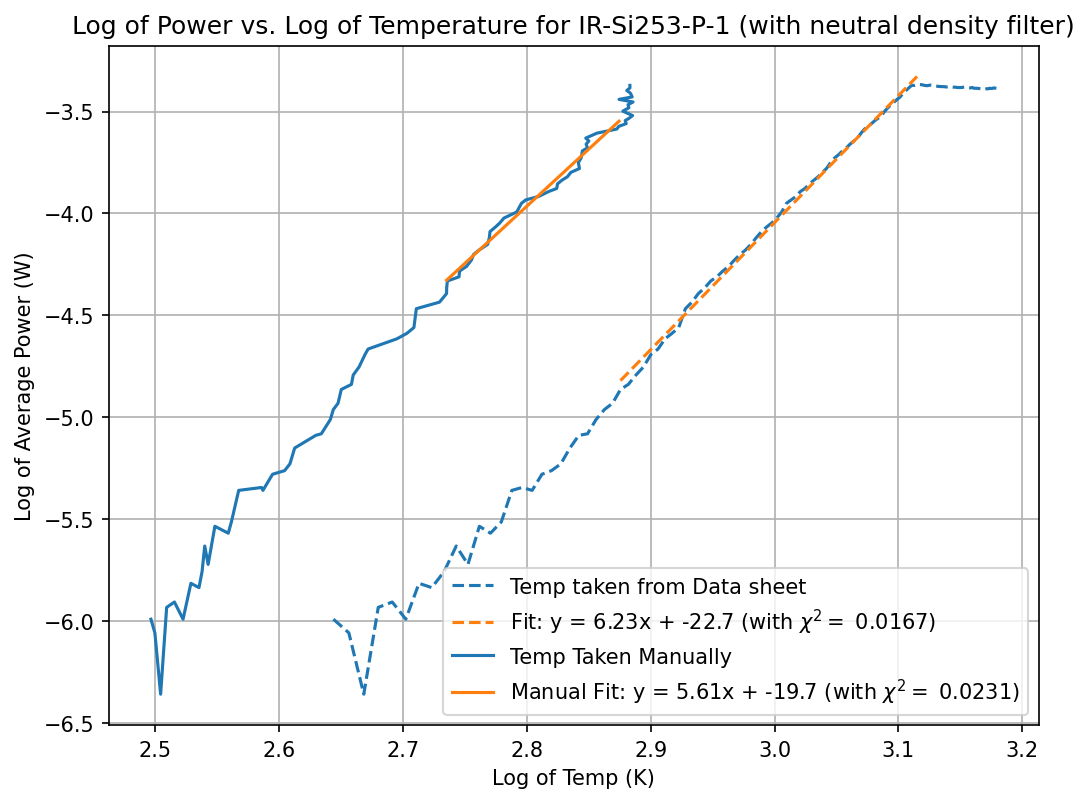

In [310]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)

if calculate_chi_sqs:
  start, end, chi = get_fit_range(temp, power)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 38
  end = 82
  chi =  0.023145015969816808

fig = figure(figsize=(8, 6), dpi=150)
poly, cov = np.polyfit(np.log10(temp[start:end]), np.log10(power[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit_manual = np.poly1d(poly)
fit_string_manual = 'Manual Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit_manual[1], fit_manual[0], chi)
print(fit_string_manual)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 
t_manual = np.linspace(np.log10(temp[start]), np.log10(temp[end]), 100)

plt.plot(np.log10(nofilter_temps_Si253), np.log10(nofilter_averages_Si253), label = "Temp taken from Data sheet", linestyle='--',)
plt.plot(t, fit(t), label = fit_string, linestyle='--',)
plt.plot(np.log10(temp), np.log10(power), label = "Temp Taken Manually", color = "C0")
plt.plot(t_manual, fit_manual(t_manual), label = fit_string_manual,  color = "C1")
title = "Log of Power vs. Log of Temperature for IR-Si253-P-1 (with neutral density filter)"
plt.title(title)
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

## IR-12K Source Plots

In [311]:
d_0 = {
'time_log_nofilter_IR12K' : [],

'power_nofilter_IR12K' : data_nofilter_IR12K['power'],
'time_nofilter_IR12K' : np.arange(0, len(data_nofilter_IR12K['power'])/5, 0.2)
}

seconds = 15
start_v = 1.1 #V
increase_v = 0.1 #V
fill_time_log_array('nofilter_IR12K', seconds, start_v, increase_v)

nofilter_voltages_IR12K, nofilter_averages_IR12K, nofilter_std_error_IR12K = get_data_auto('nofilter_IR12K', seconds)

[1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7]


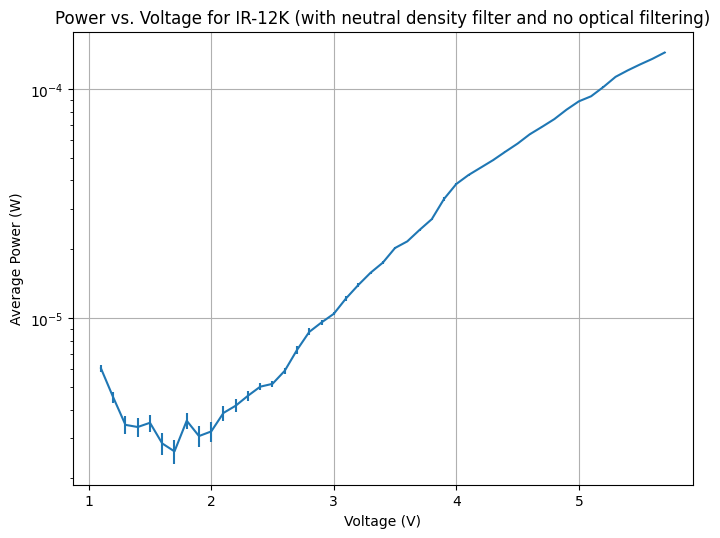

In [312]:
print(nofilter_voltages_IR12K)
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_IR12K, nofilter_averages_IR12K, yerr = nofilter_std_error_IR12K)
plt.title("Power vs. Voltage for IR-12K (with neutral density filter and no optical filtering)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.grid(True)
plt.show()

No handles with labels found to put in legend.


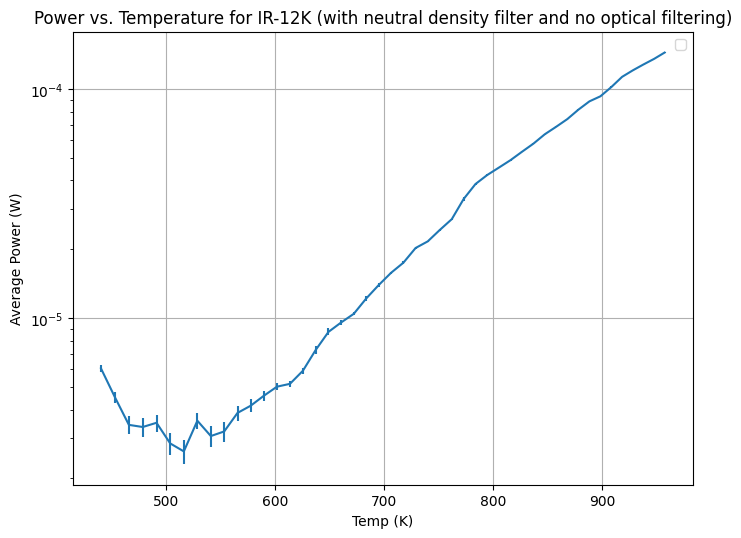

In [313]:
nofilter_temps_IR12K = Si253_temp(nofilter_voltages_IR12K)

fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_temps_IR12K, nofilter_averages_IR12K, yerr = nofilter_std_error_IR12K)

plt.title("Power vs. Temperature for IR-12K (with neutral density filter and no optical filtering)")
plt.xlabel("Temp (K)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

min chi squared updated to  0.013951446152637761  with range: [ 6 , 29 ]
min chi squared updated to  0.012281159567987423  with range: [ 7 , 30 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


min chi squared updated to  0.010385225805896906  with range: [ 10 , 33 ]
min chi squared updated to  0.00916056591402552  with range: [ 11 , 34 ]
min chi squared updated to  0.006907696541769153  with range: [ 12 , 35 ]
min chi squared updated to  0.0059390956872110165  with range: [ 15 , 38 ]
min chi squared updated to  0.0035339499281624876  with range: [ 16 , 39 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

min chi squared updated to  0.003501379467236379  with range: [ 17 , 40 ]
min chi squared updated to  0.0025284196623423885  with range: [ 18 , 41 ]
min chi squared updated to  0.0024948858876140028  with range: [ 19 , 42 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

[[nan, 1.2891775353317684e-30, 5.156710141327071e-30, 0.0038845312895349616, 0.04322163773107931, 0.051019034495956204, 0.05111115392420191, 0.05575617860660578, 0.055881317876535365, 0.05673759631895275, 0.06099531086388974, 0.061726942727816925, 0.06559259330201521, 0.06560193996996994, 0.06570784596056467, 0.07116909250216599, 0.07292669465366185, 0.07292597102840033, 0.07344905697281918, 0.07347406094843835, 0.0734734392421883, 0.07404388162388931, 0.07525210148689825, 0.07537298739743159, 0.07625363195208071, 0.07735458965343947, 0.07800947125058047, 0.07982490586881598, 0.08077995152226525, 0.08195767512804007, 0.08310510704241274, 0.08534276777674922, 0.0868232955361822, 0.08890305757033097, 0.09029939317414684, 0.09129417759140539, 0.09596786537837328, 0.09991622799010759, 0.10409765554104665, 0.10736600328071433, 0.11041180707306046, 0.11238692230914617, 0.1140047051983307, 0.11508357202279614, 0.11612002542752926, 0.11697029828242793, 0.1175121769766579], [nan, nan, 3.2050856

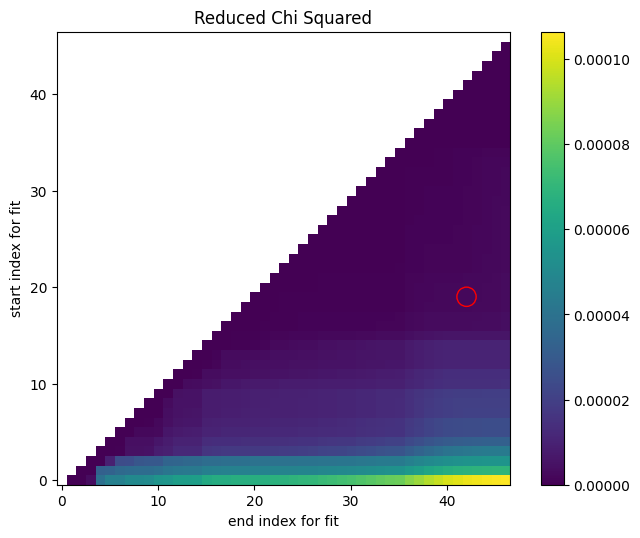

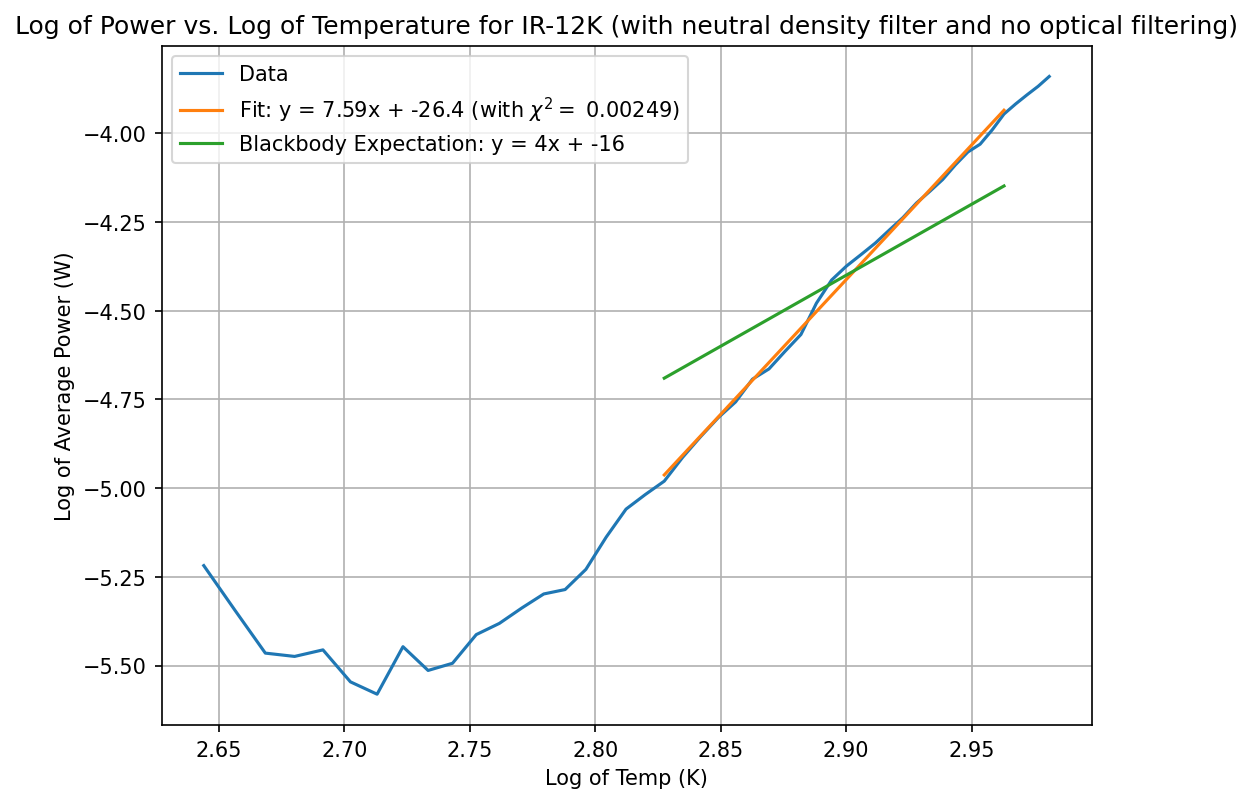

In [314]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)

if calculate_chi_sqs:
  start, end, chi = get_fit_range(nofilter_temps_IR12K, power)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 19
  end = 42
  chi =  0.0024948858876140028

fig = figure(figsize=(8, 6), dpi=150)

p, cov = np.polyfit(np.log10(nofilter_temps_IR12K[start:end]), np.log10(nofilter_averages_IR12K[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit = np.poly1d(p)
fit_string = 'Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit[1], fit[0], chi)
print(fit_string)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1]))
t = np.linspace(np.log10(nofilter_temps_IR12K[start]), np.log10(nofilter_temps_IR12K[end]), 100)

plt.plot(np.log10(nofilter_temps_IR12K), np.log10(nofilter_averages_IR12K), label = "Data")
plt.plot(t, fit(t), label = fit_string)
plt.plot(t, 4*t -16, label = "Blackbody Expectation: y = 4x + -16")
plt.title("Log of Power vs. Log of Temperature for IR-12K (with neutral density filter and no optical filtering)")
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

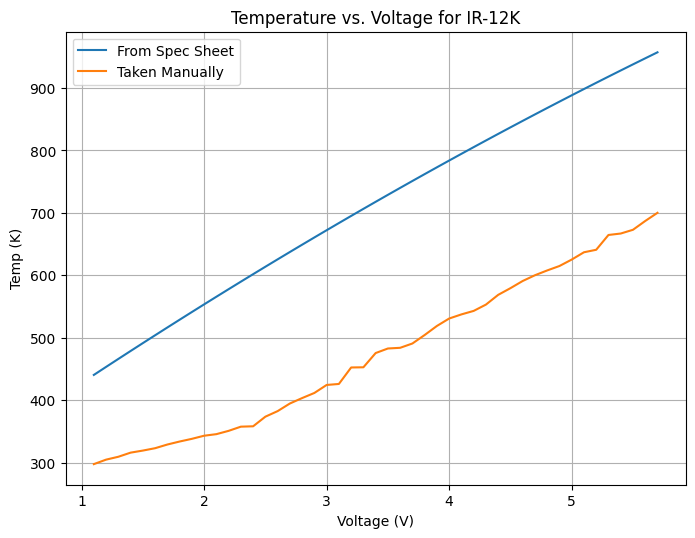

In [315]:
cleanedTempList = [x for x in IR12K_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in IR12K_temp_manual['Voltage'] if str(x) != 'nan']

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(nofilter_voltages_IR12K, nofilter_temps_IR12K, label = "From Spec Sheet")
plt.plot(cleanedVoltList, cleanedTempList, label = "Taken Manually")
plt.title("Temperature vs. Voltage for IR-12K")
plt.xlabel("Voltage (V)")
plt.ylabel("Temp (K)")

plt.legend()
plt.grid(True)
plt.show()

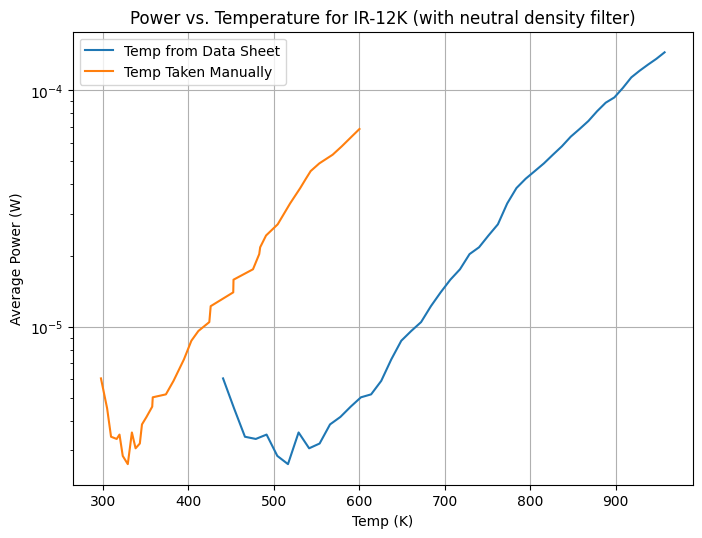

In [316]:
#eliminating any nan elements in the list
cleanedTempList = [x for x in IR12K_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in IR12K_temp_manual['Voltage'] if str(x) != 'nan']

#constructing a lookup table from voltages to temperatures 
temp_ranges = [cleanedTempList[v] for v in range(len(cleanedVoltList))] 
IR12K_volt_to_temp_manual = dict(zip(cleanedVoltList, temp_ranges))

temp = []
power = []
for i in range(len(nofilter_voltages_IR12K)):
  if i < len(cleanedTempList)-10:
    temp.append(IR12K_volt_to_temp_manual[nofilter_voltages_IR12K[i]])
    power.append(nofilter_averages_IR12K[i])

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(nofilter_temps_IR12K, nofilter_averages_IR12K, label = "Temp from Data Sheet")
plt.plot(temp, power, label = "Temp Taken Manually")
plt.title("Power vs. Temperature for IR-12K (with neutral density filter)")
plt.xlabel("Temp (K)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

min chi squared updated to  0.008425262460480453  with range: [ 5 , 23 ]
min chi squared updated to  0.007980770016455427  with range: [ 7 , 25 ]
min chi squared updated to  0.006776428036743439  with range: [ 8 , 26 ]
min chi squared updated to  0.006604045430276579  with range: [ 9 , 27 ]
min chi squared updated to  0.005386675554009029  with range: [ 10 , 28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

[[nan, 1.3813248021094615e-30, 1.0984882201119065e-29, 0.00018055282343599723, 0.0018127741028697536, 0.003866839498907922, 0.0038667714735102906, 0.004071629023488223, 0.014235933302451013, 0.016180314558623263, 0.019292551218489766, 0.02750317162031404, 0.03633596105530056, 0.046580980663690576, 0.05650874564796861, 0.06335676839804513, 0.07109563537948688, 0.08216929224688918, 0.09463245622435452, 0.10376427163811305, 0.10913063097487136, 0.11804646864043995, 0.12133879029225077, 0.12721408300172582, 0.1288399082932801, 0.13198396352560413, 0.1358054182751977, 0.14044291757693078, 0.14368421942597512, 0.14881257307614004, 0.15456853350237407, 0.1602950606055185, 0.1657725554043782, 0.16969156437179908, 0.1715234007525084, 0.17284463763551483, 0.17391956159446392], [nan, nan, 3.412239370425764e-31, 2.8293156677019453e-28, 0.0012539575148969322, 0.002090750909433076, 0.0023678009077058165, 0.0023722237252779207, 0.009020792572760013, 0.009510018449906607, 0.010621687490155431, 0.01549

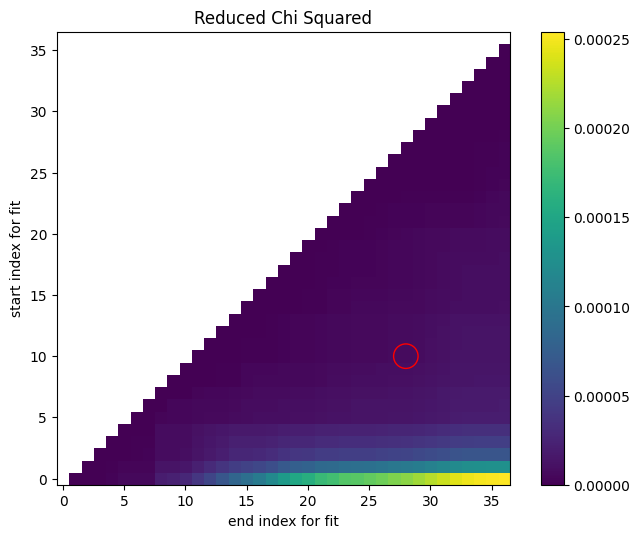

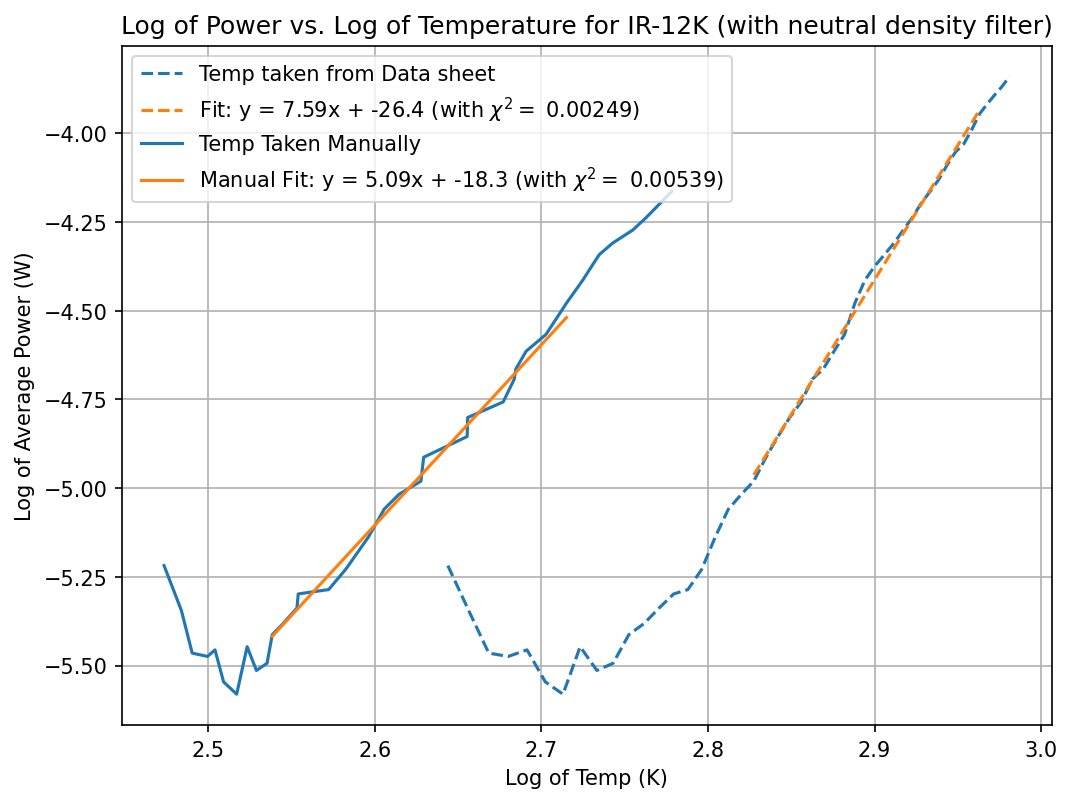

In [317]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)

if calculate_chi_sqs:
  start, end, chi = get_fit_range(temp, power)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 10
  end = 28
  chi = 0.005386675554009029

fig = figure(figsize=(8, 6), dpi=150)
poly, cov = np.polyfit(np.log10(temp[start:end]), np.log10(power[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit_manual = np.poly1d(poly)
fit_string_manual = 'Manual Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit_manual[1], fit_manual[0], chi)
print(fit_string_manual)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 
t_manual = np.linspace(np.log10(temp[start]), np.log10(temp[end]), 100)

plt.plot(np.log10(nofilter_temps_IR12K), np.log10(nofilter_averages_IR12K), label = "Temp taken from Data sheet", linestyle='--',)
plt.plot(t, fit(t), label = fit_string, linestyle='--',)
plt.plot(np.log10(temp), np.log10(power), label = "Temp Taken Manually", color = "C0")
plt.plot(t_manual, fit_manual(t_manual), label = fit_string_manual,  color = "C1")
title = "Log of Power vs. Log of Temperature for IR-12K (with neutral density filter)"
plt.title(title )
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

## EVF5551 Source Plots

Plots for EVF 5551 source. I suspect I broke this source, because the first time I took data I recieved the output plot shown in blue, where the source glowed and acted normal. The maximum voltage on the source is 1.4V, after realizing this, data was taken again at lower voltages (seen in orange) and was essentially 0.

In [318]:
d_0 = {
'time_log_nofilter_EVF_5551' : [],
'time_log_nofilter_EVF_5551_try2' : [],

'power_nofilter_EVF_5551' : data_nofilter_EVF_5551['power'],
'time_nofilter_EVF_5551' : np.arange(0, len(data_nofilter_EVF_5551['power'])/5, 0.2),

'power_nofilter_EVF_5551_try2' : data_nofilter_EVF_5551_try2['power'],
'time_nofilter_EVF_5551_try2' : np.arange(0, len(data_nofilter_EVF_5551_try2['power'])/5, 0.2)
}

seconds = 15

start_v = 1.1 #V
increase_v = 0.1 #V
fill_time_log_array('nofilter_EVF_5551', seconds, start_v, increase_v)
fill_time_log_array('nofilter_EVF_5551_try2', seconds, start_v, increase_v)

nofilter_voltages_EVF_5551, nofilter_averages_EVF_5551, nofilter_std_error_EVF_5551 = get_data_auto('nofilter_EVF_5551', seconds)
nofilter_voltages_EVF_5551_try2, nofilter_averages_EVF_5551_try2, nofilter_std_error_EVF_5551_try2 = get_data_auto('nofilter_EVF_5551_try2', seconds)

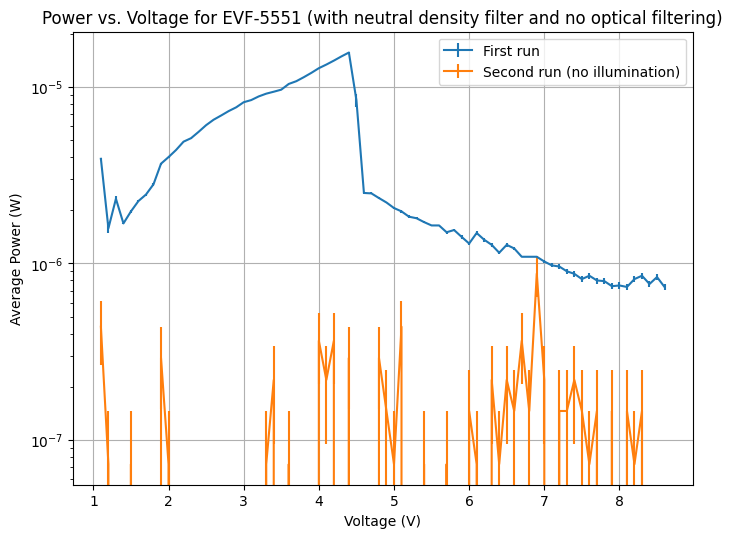

In [319]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_EVF_5551, nofilter_averages_EVF_5551, yerr = nofilter_std_error_EVF_5551, label = "First run")
plt.errorbar(nofilter_voltages_EVF_5551_try2, nofilter_averages_EVF_5551_try2, yerr = nofilter_std_error_EVF_5551_try2, label = "Second run (no illumination)")
plt.title("Power vs. Voltage for EVF-5551 (with neutral density filter and no optical filtering)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

## EVF5550 Source Plots

Plots for EVF 5550 source. This source was strategically run at low voltages to avoid damages which may have occured to the 5551 source. The first time data was taken data I recieved the output plot shown in blue, where the source glowed and acted normal. When this run was repeated at the same voltages (seen in orange) the result was essentially 0.

In [320]:
d_0 = {
'time_log_nofilter_EVF_5550' : [],
'time_log_nofilter_EVF_5550_try2' : [],

'power_nofilter_EVF_5550' : data_nofilter_EVF_5550['power'],
'time_nofilter_EVF_5550' : np.arange(0, len(data_nofilter_EVF_5550['power'])/5, 0.2),
'power_nofilter_EVF_5550_try2' : data_nofilter_EVF_5550_try2['power'],
'time_nofilter_EVF_5550_try2' : np.arange(0, len(data_nofilter_EVF_5550_try2['power'])/5, 0.2)
}

seconds = 15

start_v = 0.01 #V
increase_v = 0.01 #V
fill_time_log_array('nofilter_EVF_5550', seconds, start_v, increase_v)
fill_time_log_array('nofilter_EVF_5550_try2', seconds, start_v, increase_v)

nofilter_voltages_EVF_5550, nofilter_averages_EVF_5550, nofilter_std_error_EVF_5550 = get_data_auto('nofilter_EVF_5550', seconds)
nofilter_voltages_EVF_5550_try2, nofilter_averages_EVF_5550_try2, nofilter_std_error_EVF_5550_try2 = get_data_auto('nofilter_EVF_5550_try2', seconds)

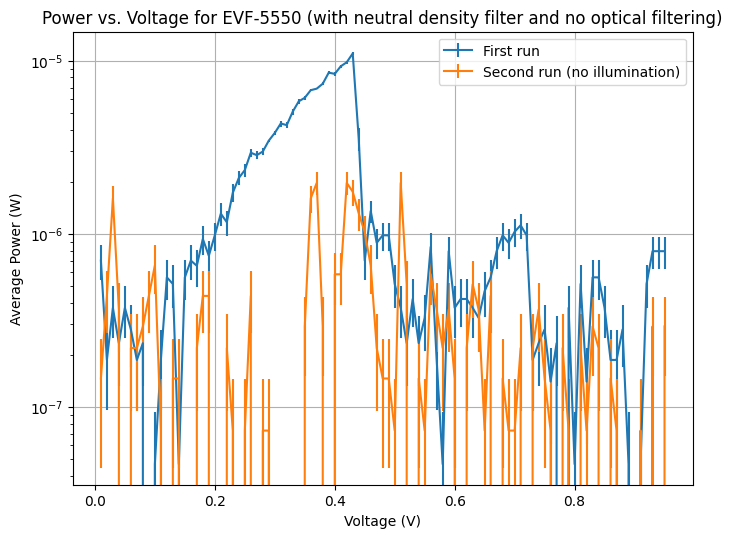

In [321]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_EVF_5550, nofilter_averages_EVF_5550, yerr = nofilter_std_error_EVF_5550, label = "First run")
plt.errorbar(nofilter_voltages_EVF_5550_try2, nofilter_averages_EVF_5550_try2, yerr = nofilter_std_error_EVF_5550_try2, label = "Second run (no illumination)")
plt.title("Power vs. Voltage for EVF-5550 (with neutral density filter and no optical filtering)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

## Si207 Source Plots

In [322]:
d_0 = {
'time_log_nofilter_Si207' : [],
'time_log_nofilter_Si207_633nm' : [],
'time_log_nofilter_Si207_1e4nm' : [],
'time_log_nofilter_Si207_5e4nm' : [],
'time_log_nofilter_Si207_3e5nm' : [],
'time_log_PEWfilter_Si207' : [],
'time_log_SiWfilter_Si207' : [],

'power_nofilter_Si207' : data_nofilter_Si207['power'],
'time_nofilter_Si207' : np.arange(0, len(data_nofilter_Si207['power'])/5, 0.2),

'power_nofilter_Si207_633nm' : data_nofilter_Si207_633nm['power'],
'time_nofilter_Si207_633nm' : np.arange(0, len(data_nofilter_Si207_633nm['power'])/5, 0.2),

'power_nofilter_Si207_1e4nm' : data_nofilter_Si207_1e4nm['power'],
'time_nofilter_Si207_1e4nm' : np.arange(0, len(data_nofilter_Si207_1e4nm['power'])/5, 0.2),

'power_nofilter_Si207_3e5nm' : data_nofilter_Si207_3e5nm['power'],
'time_nofilter_Si207_3e5nm' : np.arange(0, len(data_nofilter_Si207_3e5nm['power'])/5, 0.2),

'power_nofilter_Si207_5e4nm' : data_nofilter_Si207_5e4nm['power'],
'time_nofilter_Si207_5e4nm' : np.arange(0, len(data_nofilter_Si207_5e4nm['power'])/5, 0.2),


'power_PEWfilter_Si207' : data_PEWfilter_Si207['power'],
'time_PEWfilter_Si207' : np.arange(0, len(data_PEWfilter_Si207['power'])/5, 0.2),

'power_SiWfilter_Si207' : data_SiWfilter_Si207['power'],
'time_SiWfilter_Si207' : np.arange(0, len(data_SiWfilter_Si207['power'])/5, 0.2)
}

seconds = 15
start_v = 1.1 #V
increase_v = 0.1 #V
fill_time_log_array('SiWfilter_Si207', seconds, start_v, increase_v)
fill_time_log_array('PEWfilter_Si207', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si207', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si207_633nm', seconds, 1.3, increase_v)
fill_time_log_array('nofilter_Si207_1e4nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si207_3e5nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si207_5e4nm', seconds, start_v, increase_v)

nofilter_voltages_Si207, nofilter_averages_Si207, nofilter_std_error_Si207 = get_data_auto('nofilter_Si207', 15)
nofilter_voltages_Si207_633nm, nofilter_averages_Si207_633nm, nofilter_std_error_Si207_633nm = get_data_auto('nofilter_Si207_633nm', 15)
nofilter_voltages_Si207_1e4nm, nofilter_averages_Si207_1e4nm, nofilter_std_error_Si207_1e4nm = get_data_auto('nofilter_Si207_1e4nm', 15)
nofilter_voltages_Si207_3e5nm, nofilter_averages_Si207_3e5nm, nofilter_std_error_Si207_3e5nm = get_data_auto('nofilter_Si207_3e5nm', 15)
nofilter_voltages_Si207_5e4nm, nofilter_averages_Si207_5e4nm, nofilter_std_error_Si207_5e4nm = get_data_auto('nofilter_Si207_5e4nm', 15)
PEWfilter_voltages_Si207, PEWfilter_averages_Si207, PEWfilter_std_error_Si207 = get_data_auto('PEWfilter_Si207', 15)
SiWfilter_voltages_Si207, SiWfilter_averages_Si207, SiWfilter_std_error_Si207 = get_data_auto('SiWfilter_Si207',15)

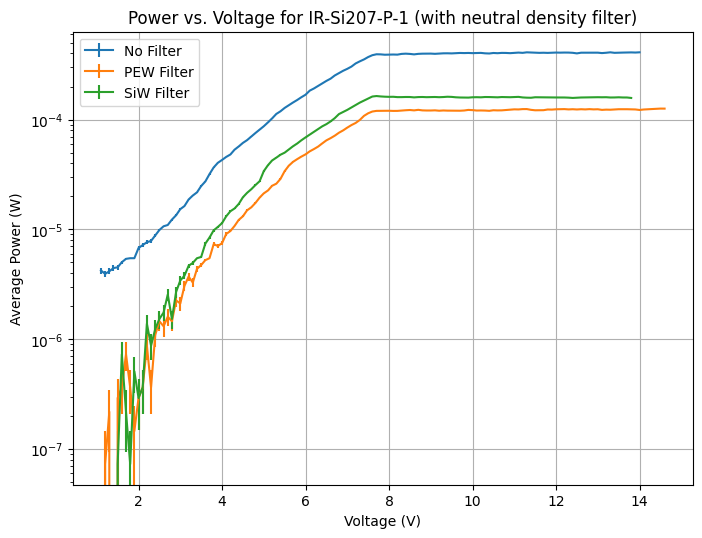

In [323]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si207, nofilter_averages_Si207, yerr = nofilter_std_error_Si207, label = "No Filter")
plt.errorbar(PEWfilter_voltages_Si207, PEWfilter_averages_Si207, yerr = PEWfilter_std_error_Si207, label = "PEW Filter")
plt.errorbar(SiWfilter_voltages_Si207, SiWfilter_averages_Si207, yerr = SiWfilter_std_error_Si207, label = "SiW Filter")
plt.title("Power vs. Voltage for IR-Si207-P-1 (with neutral density filter)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()


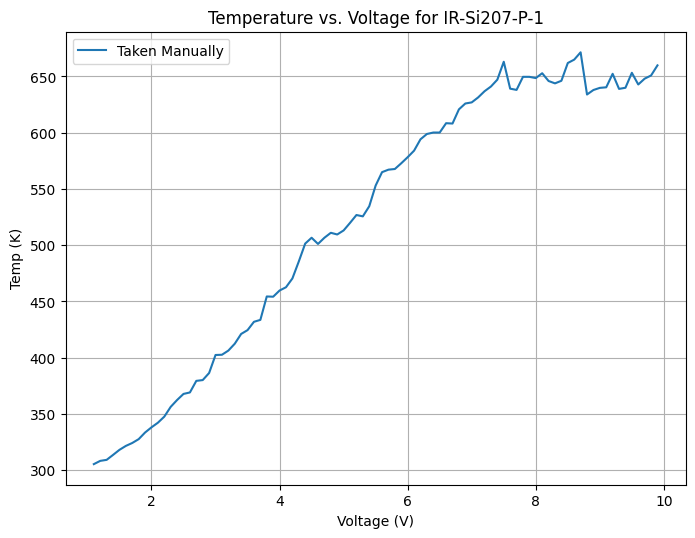

In [324]:
cleanedTempList = [x for x in Si207_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in Si207_temp_manual['Voltage'] if str(x) != 'nan']

#constructing a lookup table from voltages to temperatures 
temp_ranges = [cleanedTempList[v] for v in range(len(cleanedVoltList))] 
Si207_volt_to_temp_manual = dict(zip(cleanedVoltList, temp_ranges))

temp = []
power = []
for i in range(len(nofilter_voltages_Si207)):
  if i < len(cleanedTempList)-10:
    temp.append(Si207_volt_to_temp_manual[nofilter_voltages_Si207[i]])
    power.append(nofilter_averages_Si207[i])

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(cleanedVoltList, cleanedTempList, label = "Taken Manually")
plt.title("Temperature vs. Voltage for IR-Si207-P-1")
plt.xlabel("Voltage (V)")
plt.ylabel("Temp (K)")

plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packa

min chi squared updated to  0.02501317340964845  with range: [ 10 , 49 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


min chi squared updated to  0.023612138250917212  with range: [ 11 , 50 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


min chi squared updated to  0.022725925347266845  with range: [ 12 , 51 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packa

min chi squared updated to  0.022426381988126947  with range: [ 17 , 56 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


min chi squared updated to  0.021459970809118736  with range: [ 20 , 59 ]
min chi squared updated to  0.020950329624638338  with range: [ 21 , 60 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


min chi squared updated to  0.020717073897911047  with range: [ 24 , 63 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packa

[[nan, 1.3612124331091478e-30, 9.254679038130131e-29, 0.00016763661910847836, 0.0004299615055982556, 0.00043031394354316204, 0.0006519260722689695, 0.0008954663845857493, 0.0008976663252448098, 0.0011756371551375597, 0.0018382337977401772, 0.0021519101828649705, 0.0022042012096418788, 0.0025225259220095636, 0.0025419109161390714, 0.002608242670342101, 0.00306685676578103, 0.0031989805683699706, 0.003533578408591341, 0.0038208733784211445, 0.0038666201506744576, 0.003990922961530036, 0.0051177229179940045, 0.0059735567562251, 0.00613096751404456, 0.007350798614573821, 0.008270283461426059, 0.012220162995025681, 0.01264312324225993, 0.014662140599504467, 0.015987945368586613, 0.01755037289207209, 0.018017744570456174, 0.018038981178763354, 0.019490958221005713, 0.020330738322574014, 0.020413569051109536, 0.020554968522698686, 0.02085942794360968, 0.02258247945756231, 0.02475921272717134, 0.02671805525190232, 0.028508800779488443, 0.033459276864534745, 0.03614222684666864, 0.0362162942327

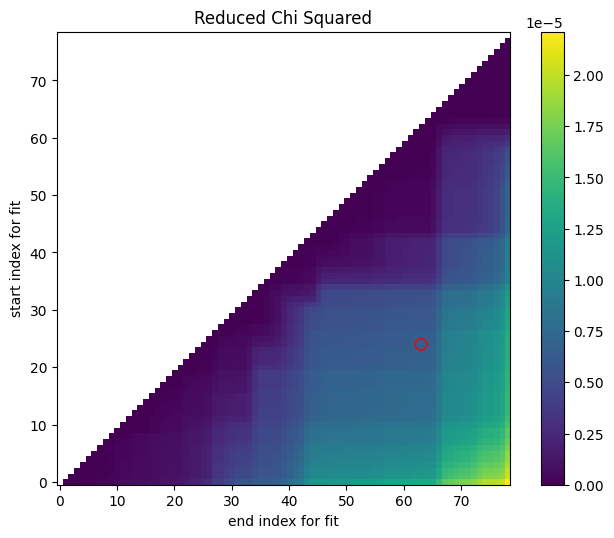

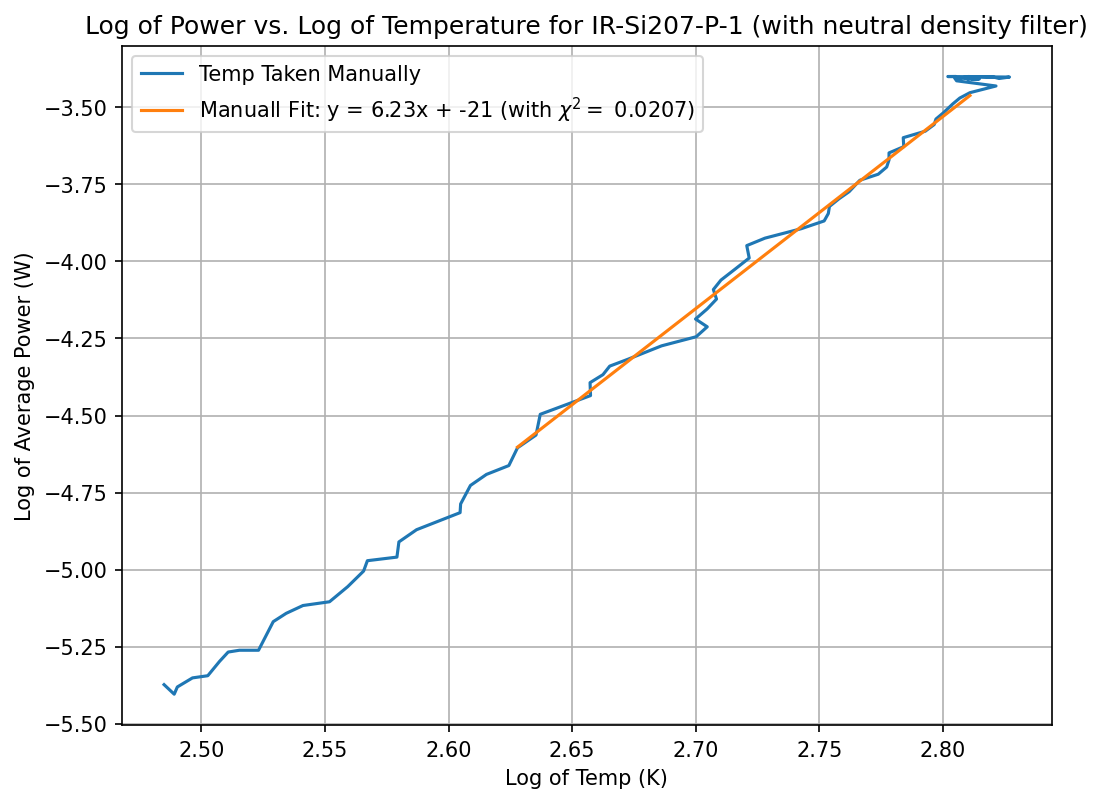

In [325]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)
if calculate_chi_sqs:
  start, end, chi = get_fit_range(temp, power)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 24
  end = 63
  chi = 0.020717073897911047

fig = figure(figsize=(8, 6), dpi=150)
poly, cov = np.polyfit(np.log10(temp[start:end]), np.log10(power[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit_manual = np.poly1d(poly)
fit_string_manual = 'Manuall Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit_manual[1], fit_manual[0], chi)
print(fit_string_manual)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 
t_manual = np.linspace(np.log10(temp[start]), np.log10(temp[end]), 100)

plt.plot(np.log10(temp), np.log10(power), label = "Temp Taken Manually")
plt.plot(t_manual, fit_manual(t_manual), label = fit_string_manual)
plt.title("Log of Power vs. Log of Temperature for IR-Si207-P-1 (with neutral density filter)")
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

# This section begins random comparison plots to investigate behaviors

This plot is still for the Si253 source. Investigates the difference in data taking time at each voltage step. The 15 second data point means the source was fixed at a input voltage for 15 seconds (with step size of 0.1V) and 30 seconds means the source was fixed for 30 seconds at an input voltage. 

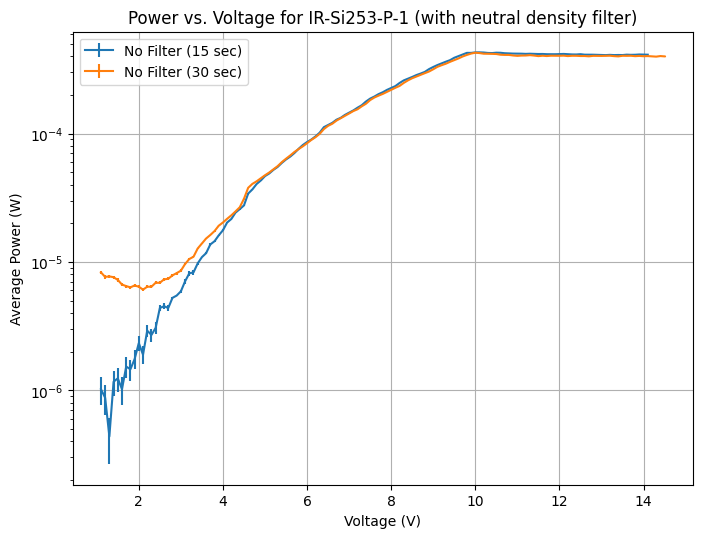

In [326]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si253, nofilter_averages_Si253, yerr = nofilter_std_error_Si253, label = "No Filter (15 sec)")
plt.errorbar(nofilter_voltages_Si253_30sec, nofilter_averages_Si253_30sec, yerr = nofilter_std_error_Si253_30sec, label = "No Filter (30 sec)")
plt.title("Power vs. Voltage for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

This plot shows the differnece made by the neutral density filter (piece of cardboard with hole in it). There is a clear amount of optical power being allowed through the filter thanks to the hole in the cardboard. 

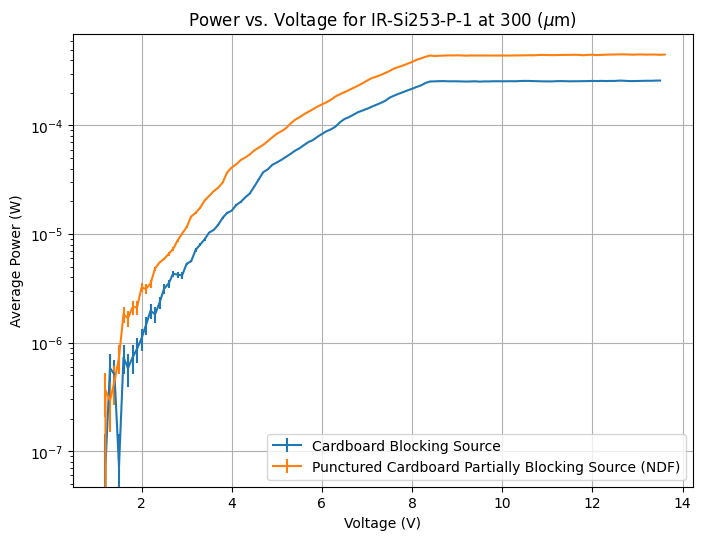

In [327]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si253_block, nofilter_averages_Si253_block, yerr = nofilter_std_error_Si253_block, label = "Cardboard Blocking Source") 
plt.errorbar(nofilter_voltages_Si253_3e5nm, nofilter_averages_Si253_3e5nm, yerr = nofilter_std_error_Si253_3e5nm, label = "Punctured Cardboard Partially Blocking Source (NDF)") 
plt.title("Power vs. Voltage for IR-Si253-P-1 at 300 ($\mu$m) ")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

### These four plots (three of Si253 and one of Si207 respectivley) compare data taken where the selected wavelength of investigation on the detector is modified. Final results conclude that the detector measures overall power and multiplies the measured value by some adjustment value accoridng to it's acceptance as a function of wavlength. The final reuslts are shown in the typical and then log scale (2nd and 3rd plot), comparing the power at various wavlengths for a fixed temperaute.  This plot has the same shape as the detector's acceptance plot. 

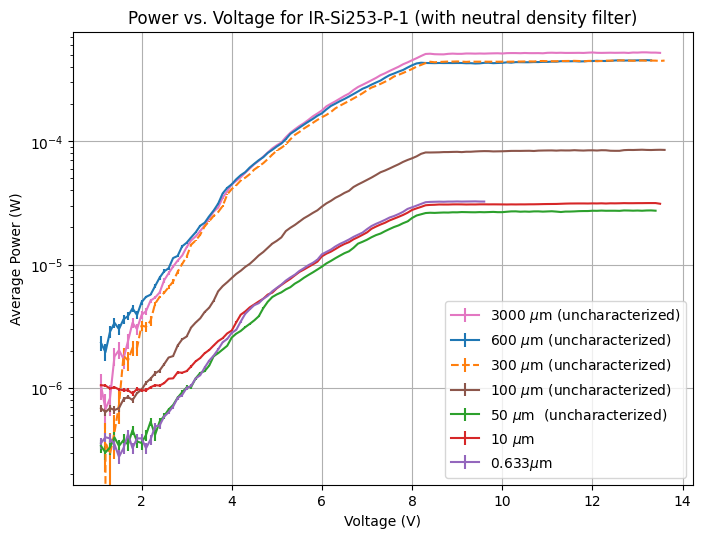

In [328]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si253_3e6nm, nofilter_averages_Si253_3e6nm, yerr = nofilter_std_error_Si253_3e6nm, label = "3000 $\mu$m (uncharacterized)", color = 'C6') 
plt.errorbar(nofilter_voltages_Si253_6e5nm, nofilter_averages_Si253_6e5nm, yerr = nofilter_std_error_Si253_6e5nm, label = "600 $\mu$m (uncharacterized)", color = 'C0')  
#plt.errorbar(nofilter_voltages_Si253, nofilter_averages_Si253, yerr = nofilter_std_error_Si253, label = "300 $\mu$m (uncharacterized) data taken Feb. 25", color='C1')
#plt.errorbar(nofilter_voltages_Si253_3e5nm, nofilter_averages_Si253_3e5nm, yerr = nofilter_std_error_Si253_3e5nm, label = "300 $\mu$m (uncharacterized) data taken Mar. 5", linestyle='--', color='C1')#
plt.errorbar(nofilter_voltages_Si253_3e5nm, nofilter_averages_Si253_3e5nm, yerr = nofilter_std_error_Si253_3e5nm, label = "300 $\mu$m (uncharacterized)", linestyle='--', color='C1')
plt.errorbar(nofilter_voltages_Si253_1e5nm, nofilter_averages_Si253_1e5nm, yerr = nofilter_std_error_Si253_1e5nm, label = "100 $\mu$m (uncharacterized)", color = 'C5')
plt.errorbar(nofilter_voltages_Si253_5e4nm, nofilter_averages_Si253_5e4nm, yerr = nofilter_std_error_Si253_5e4nm, label = "50 $\mu$m  (uncharacterized)", color = 'C2')
plt.errorbar(nofilter_voltages_Si253_1e4nm, nofilter_averages_Si253_1e4nm, yerr = nofilter_std_error_Si253_1e4nm, label = "10 $\mu$m", color = 'C3')
plt.errorbar(nofilter_voltages_Si253_633nm, nofilter_averages_Si253_633nm, yerr = nofilter_std_error_Si253_633nm, label = "0.633$\mu$m", color = 'C4')
plt.title("Power vs. Voltage for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

No handles with labels found to put in legend.


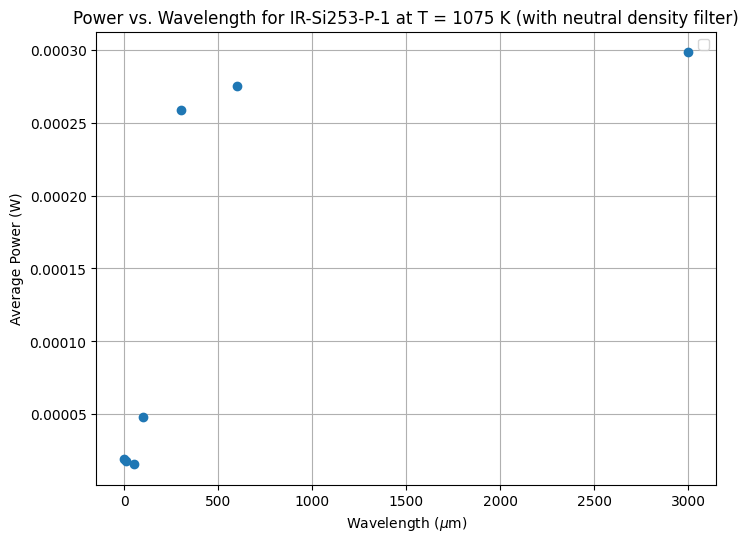

In [329]:
power_wavelength = []
power_wavelength.append([get_power(nofilter_voltages_Si253_3e6nm, nofilter_averages_Si253_3e6nm, 7),3000])
power_wavelength.append([get_power(nofilter_voltages_Si253_6e5nm, nofilter_averages_Si253_6e5nm, 7), 600])
power_wavelength.append([get_power(nofilter_voltages_Si253_3e5nm, nofilter_averages_Si253_3e5nm, 7), 300])
power_wavelength.append([get_power(nofilter_voltages_Si253_1e5nm, nofilter_averages_Si253_1e5nm, 7), 100])
power_wavelength.append([get_power(nofilter_voltages_Si253_5e4nm, nofilter_averages_Si253_5e4nm, 7), 50])
power_wavelength.append([get_power(nofilter_voltages_Si253_1e4nm, nofilter_averages_Si253_1e4nm, 7), 10])
power_wavelength.append([get_power(nofilter_voltages_Si253_633nm, nofilter_averages_Si253_633nm, 7), 0.633])
powerwavelength = np.asarray(power_wavelength, dtype=np.float32)

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(powerwavelength[:,1], powerwavelength[:,0], marker='o', linestyle = "None")
plt.title("Power vs. Wavelength for IR-Si253-P-1 at T = 1075 K (with neutral density filter)")
plt.xlabel("Wavelength ($\mu$m)")
plt.ylabel("Average Power (W)")
plt.legend()
#plt.yscale("log")
#plt.xscale("log")
plt.grid(True)
plt.show()

No handles with labels found to put in legend.


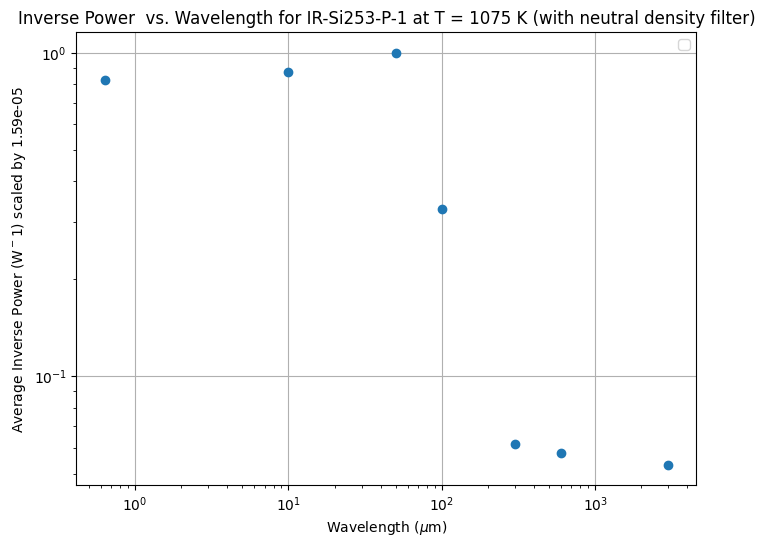

In [330]:
one_over = 1/powerwavelength
wavelength_plot_new = one_over*np.min(powerwavelength[:,0])

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(powerwavelength[:,1], wavelength_plot_new[:,0], marker='o', linestyle = "None")
plt.title("Inverse Power  vs. Wavelength for IR-Si253-P-1 at T = 1075 K (with neutral density filter)")
plt.xlabel("Wavelength ($\mu$m)")

ystr = 'Average Inverse Power (W$^-1$) scaled by {0:.3g} '.format(np.min(powerwavelength[:,0])) 
plt.ylabel(ystr)
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

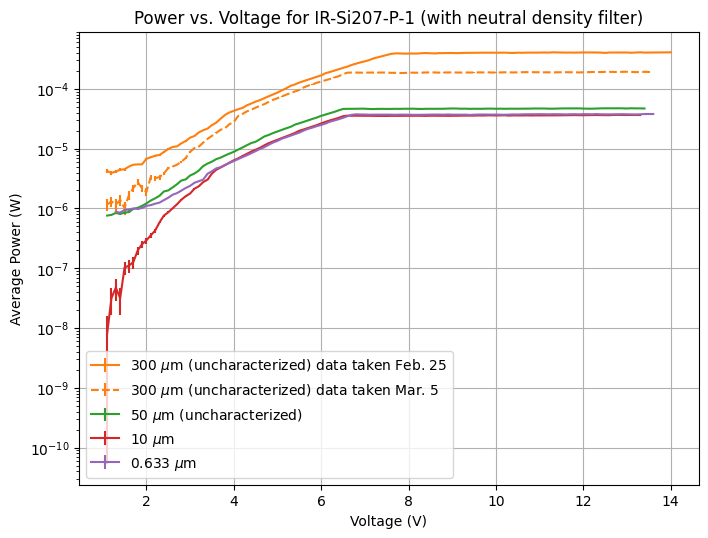

In [331]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si207, nofilter_averages_Si207, yerr = nofilter_std_error_Si207, label = "300 $\mu$m (uncharacterized) data taken Feb. 25", color = "C1")
plt.errorbar(nofilter_voltages_Si207_3e5nm, nofilter_averages_Si207_3e5nm, yerr = nofilter_std_error_Si207_3e5nm, label = "300 $\mu$m (uncharacterized) data taken Mar. 5", linestyle='--', color = "C1")
plt.errorbar(nofilter_voltages_Si207_5e4nm, nofilter_averages_Si207_5e4nm, yerr = nofilter_std_error_Si207_5e4nm, label = "50 $\mu$m (uncharacterized)", color = 'C2')
plt.errorbar(nofilter_voltages_Si207_1e4nm, nofilter_averages_Si207_1e4nm, yerr = nofilter_std_error_Si207_1e4nm, label = "10 $\mu$m", color = 'C3')
plt.errorbar(nofilter_voltages_Si207_633nm, nofilter_averages_Si207_633nm, yerr = nofilter_std_error_Si207_633nm, label = "0.633 $\mu$m", color = 'C4')
plt.title("Power vs. Voltage for IR-Si207-P-1 (with neutral density filter)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

## Background Power (no source)

In [332]:
def get_std_error(array):
  std_dev = np.sqrt(np.var(array))
  std_error = std_dev/np.sqrt(len(array))
  return(std_error)

d_0 = {'power_nosource' : data_nosource['power'] }
avg_power_nosource = np.mean(d_0['power_nosource'])
err_power_nosource = get_std_error(d_0['power_nosource'])

print("background power is " , avg_power_nosource, u"\u00B1", err_power_nosource , "W")

background power is  1.258559195716976e-08 ± 7.895543912493363e-11 W


## LED Source Plots

The goal of these data is to show how much optical power the detector measures for an LED with a narrow wavelength range (2.35 micron). It is expected that the SiW optical filter should allow light in the ranges: [1.1$\mu$m, 9.9$\mu$m] & [50$\mu$m, 1000$\mu$m] meaning the detector can observe the LED with the SiW filter in place, whereas the PEW filter should not allow the LED to reach the detector, since its optical range is [10$\mu$m, 1000$\mu$m].

Also, the Noise Equivalent power accoring to the detector speifications is 5nW. This will also be plotted for visualtization purposes.  

No handles with labels found to put in legend.


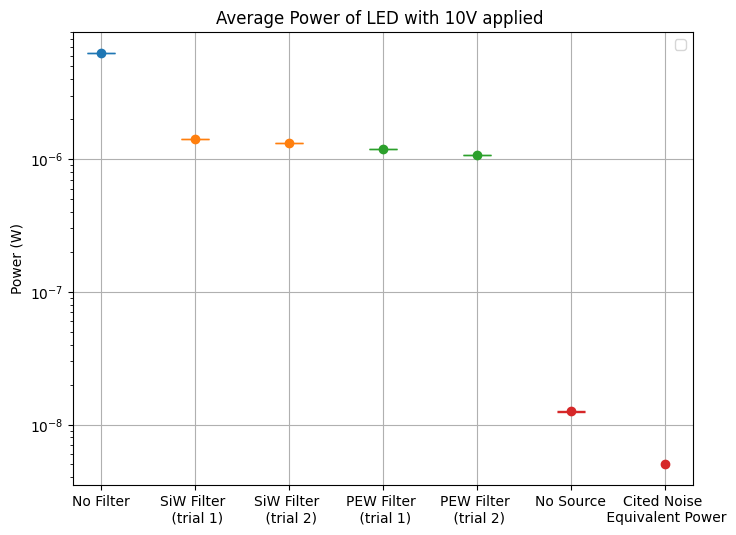

In [336]:
d_0 = {
'power_data_LED_nofilter' : data_LED_nofilter['power'],
'power_data_LED_SiWfilter1' : data_LED_SiWfilter1['power'],
'power_data_LED_SiWfilter2' : data_LED_SiWfilter2['power'],
'power_data_LED_PEWfilter1' : data_LED_PEWfilter1['power'],
'power_data_LED_PEWfilter2' : data_LED_PEWfilter2['power'],
}

noise_equivalent_power = 5e-9

avg_power_LED_nofilter = np.mean(d_0['power_data_LED_nofilter'])
avg_power_LED_SiWfilter1 = np.mean(d_0['power_data_LED_SiWfilter1'])
avg_power_LED_SiWfilter2 = np.mean(d_0['power_data_LED_SiWfilter2'])
avg_power_LED_PEWfilter1 = np.mean(d_0['power_data_LED_PEWfilter1'])
avg_power_LED_PEWfilter2 = np.mean(d_0['power_data_LED_PEWfilter2'])

err_power_LED_nofilter = get_std_error(d_0['power_data_LED_nofilter'])
err_power_LED_SiWfilter1 = get_std_error(d_0['power_data_LED_SiWfilter1'])
err_power_LED_SiWfilter2 = get_std_error(d_0['power_data_LED_SiWfilter2'])
err_power_LED_PEWfilter1 = get_std_error(d_0['power_data_LED_PEWfilter1'])
err_power_LED_PEWfilter2 = get_std_error(d_0['power_data_LED_PEWfilter2'])

fig = figure(figsize=(8, 6), dpi=100)
x = np.arange(8)
plt.xticks(x, ('', 'No Filter', 'SiW Filter \n (trial 1)', 'SiW Filter \n (trial 2)', 'PEW Filter \n (trial 1)', 'PEW Filter \n (trial 2)', 'No Source', 'Cited Noise \n Equivalent Power'))

plt.errorbar(1, avg_power_LED_nofilter, yerr = err_power_LED_nofilter, color = "C0", fmt='o', capsize=10)
plt.errorbar(2, avg_power_LED_SiWfilter1, yerr = err_power_LED_SiWfilter1, color = "C1", fmt='o', capsize=10)
plt.errorbar(3, avg_power_LED_SiWfilter2, yerr = err_power_LED_SiWfilter2,  color = 'C1', fmt='o', capsize=10)
plt.errorbar(4, avg_power_LED_PEWfilter1, yerr = err_power_LED_PEWfilter1, color = 'C2', fmt='o', capsize=10)
plt.errorbar(5, avg_power_LED_PEWfilter2, yerr = err_power_LED_PEWfilter2, color = 'C2', fmt='o', capsize=10)
plt.errorbar(6, avg_power_nosource, yerr = err_power_nosource, color = 'C3', fmt='o', capsize=10)
plt.plot(7,noise_equivalent_power,'o', color = 'C3')

plt.title("Average Power of LED with 10V applied ")
plt.ylabel("Power (W)")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

No handles with labels found to put in legend.


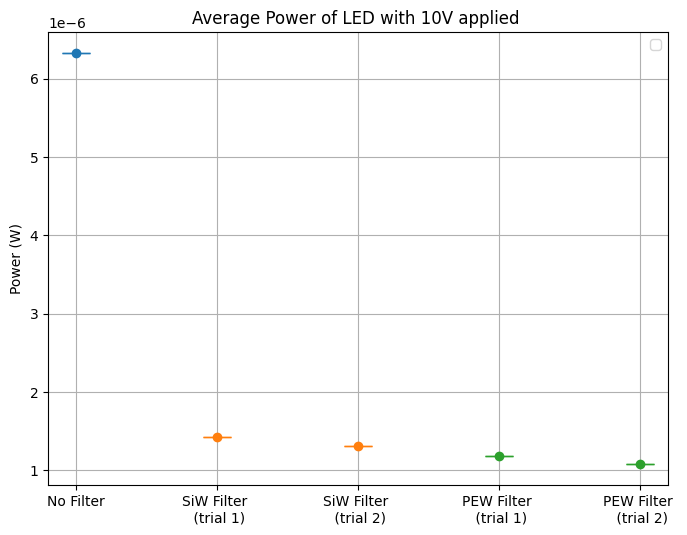

In [339]:
fig = figure(figsize=(8, 6), dpi=100)
x = np.arange(8)
plt.xticks(x, ('', 'No Filter', 'SiW Filter \n (trial 1)', 'SiW Filter \n (trial 2)', 'PEW Filter \n (trial 1)', 'PEW Filter \n (trial 2)', 'No Source', 'Cited Noise \n Equivalent Power'))

plt.errorbar(1, avg_power_LED_nofilter, yerr = err_power_LED_nofilter, color = "C0", fmt='o', capsize=10)
plt.errorbar(2, avg_power_LED_SiWfilter1, yerr = err_power_LED_SiWfilter1, color = "C1", fmt='o', capsize=10)
plt.errorbar(3, avg_power_LED_SiWfilter2, yerr = err_power_LED_SiWfilter2,  color = 'C1', fmt='o', capsize=10)
plt.errorbar(4, avg_power_LED_PEWfilter1, yerr = err_power_LED_PEWfilter1, color = 'C2', fmt='o', capsize=10)
plt.errorbar(5, avg_power_LED_PEWfilter2, yerr = err_power_LED_PEWfilter2, color = 'C2', fmt='o', capsize=10)

plt.title("Average Power of LED with 10V applied ")
plt.ylabel("Power (W)")
plt.legend()
plt.grid(True)
plt.show()

In [338]:
print("relative power for SiW filter is " , np.mean([avg_power_LED_SiWfilter1, avg_power_LED_SiWfilter2])/ avg_power_LED_nofilter )
print("relative power for PEW filter is " , np.mean([avg_power_LED_PEWfilter1, avg_power_LED_PEWfilter2])/ avg_power_LED_nofilter )

relative power for SiW filter is  0.2159291332474294
relative power for PEW filter is  0.17850823822736392


In [340]:
print(avg_power_LED_nofilter)

6.328151549942651e-06
